In [1]:
#Add new directory to path to import ngs and pserm
import sys
import os
path = os.getcwd()
path_with_ngs_and_pserm = os.path.dirname(path)

sys.path.append(path_with_ngs_and_pserm)

#Imports 
import tqdm
import matplotlib
import numpy as np
import pandas as pd
from ngs import NGS_round_data, NGS_DMD, common_clones
from pserm import ngs_analysis, generate_clone_set
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import spearmanr, pearsonr

#specify font properties for better export into adobe illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#Add myriad pro font
fpath = "/Library/Fonts/Myriad Pro Regular.ttf"
aapath = '/Library/Fonts/cour.ttf'

prop = fm.FontProperties(fname=fpath, size = 20)
tickprop = fm.FontProperties(fname = fpath, size = 16)
aaprop = fm.FontProperties(fname = aapath, size = 16)

NGS package imported


# Reproducibility

# Project 1

## setups and data processing

In [2]:
#Project 1 NGS_round_data setups
p1_wt = 'YRRRGAWY'

p1_muts_no_wt = {
  0: ['A', 'D', 'F', 'S', 'V'],
  1: ['A', 'E', 'G', 'K', 'T'],
  2: ['A', 'E', 'G', 'K', 'T'],
  3: ['A', 'E', 'G', 'K', 'T'],
  4: ['A', 'D', 'N', 'S', 'T'],
  5: ['D', 'F', 'S', 'V', 'Y'],
  6: ['L', 'G', 'V', 'S', 'A'],
  7: ['A', 'D', 'F', 'S', 'V']
}

p1_r1 = NGS_round_data(
    Round = 3, 
    sequence_type = 'mutations', 
    samples =[
        'Input',
        'Ag1_P',
        'Ag01_P',
        'DA_P',
        'PSR_P',
        'PSR_N',
        'Ins_P',
        'Ins_N',
        'Ova_P',
        'Ova_N'],
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_1/Rep_1', 
    wild_type = p1_wt, 
    mutations_dict = p1_muts_no_wt
)

p1_r2 = NGS_round_data(
    Round = 3, 
    sequence_type = 'mutations', 
    samples =[
        'Input',
        'Ag1_P',
        'Ag01_P',
        'DA_P',
        'PSR_P',
        'PSR_N', #I've changed this from PSR_NS to help with PSSM creation.
        'PSR_NB',
        'Ins_P',
        'Ins_NS',
        'Ins_NB',
        'Ova_P',
        'Ova_N',#I've changed this from Ova_NS to help with PSSM creation.
        'Ova_NB'],
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_1/Rep_2', 
    wild_type = p1_wt, 
    mutations_dict = p1_muts_no_wt
)

mut_pos = [32, 49, 54, 55, 56, 98, 100, 103]

['Mutation_139624.csv', 'Mutation_139625.csv', 'Mutation_139626.csv', 'Mutation_139627.csv', 'Mutation_139628.csv', 'Mutation_139629.csv', 'Mutation_139630.csv', 'Mutation_139631.csv', 'Mutation_139632.csv', 'Mutation_139633.csv']
['Mutation_140403.csv', 'Mutation_140404.csv', 'Mutation_140405.csv', 'Mutation_140406.csv', 'Mutation_140407.csv', 'Mutation_140408.csv', 'Mutation_140409.csv', 'Mutation_140410.csv', 'Mutation_140411.csv', 'Mutation_140412.csv', 'Mutation_140413.csv', 'Mutation_140414.csv', 'Mutation_140415.csv']


In [3]:
p1_clone_set_trimmed_r1 = generate_clone_set(p1_r1, ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N'])
p1_clone_set_trimmed_r2 = generate_clone_set(p1_r2, ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N'])

p1_data_r1 = ngs_analysis([p1_r1], ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N'], clone_set = p1_clone_set_trimmed_r1)
p1_data_r2 = ngs_analysis([p1_r2], ['Input', 'Ag1_P', 'Ag01_P', 'PSR_P', 'PSR_N', 'Ova_P', 'Ova_N'], clone_set = p1_clone_set_trimmed_r2)

p1_data_r1.generate_D()
p1_data_r2.generate_D()

100%|██████████| 694296/694296 [00:01<00:00, 457536.71it/s]


In [4]:
for sample in tqdm.tqdm(p1_data_r1.samples):
    p1_data_r1.generate_PSSM(sample)
    p1_data_r2.generate_PSSM(sample)

    #because Input is first sample for this project I can create PSERM during PSSM creation.
    if sample != 'Input':
        p1_data_r1.generate_PSERM(In_sample = 'Input', Out_sample = sample)
        p1_data_r2.generate_PSERM(In_sample = 'Input', Out_sample = sample)


  0%|          | 0/7 [00:00<?, ?it/s]

Generating MSA.


100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Generating MSA.


100%|██████████| 7/7 [01:49<00:00, 15.63s/it]


In [5]:
p1_data_r1.score_all_clones_mp(method = 'PSERM')
p1_data_r2.score_all_clones_mp(method = 'PSERM')

Done in 7.05 minutes
Done in 4.5 minutes


## Plots

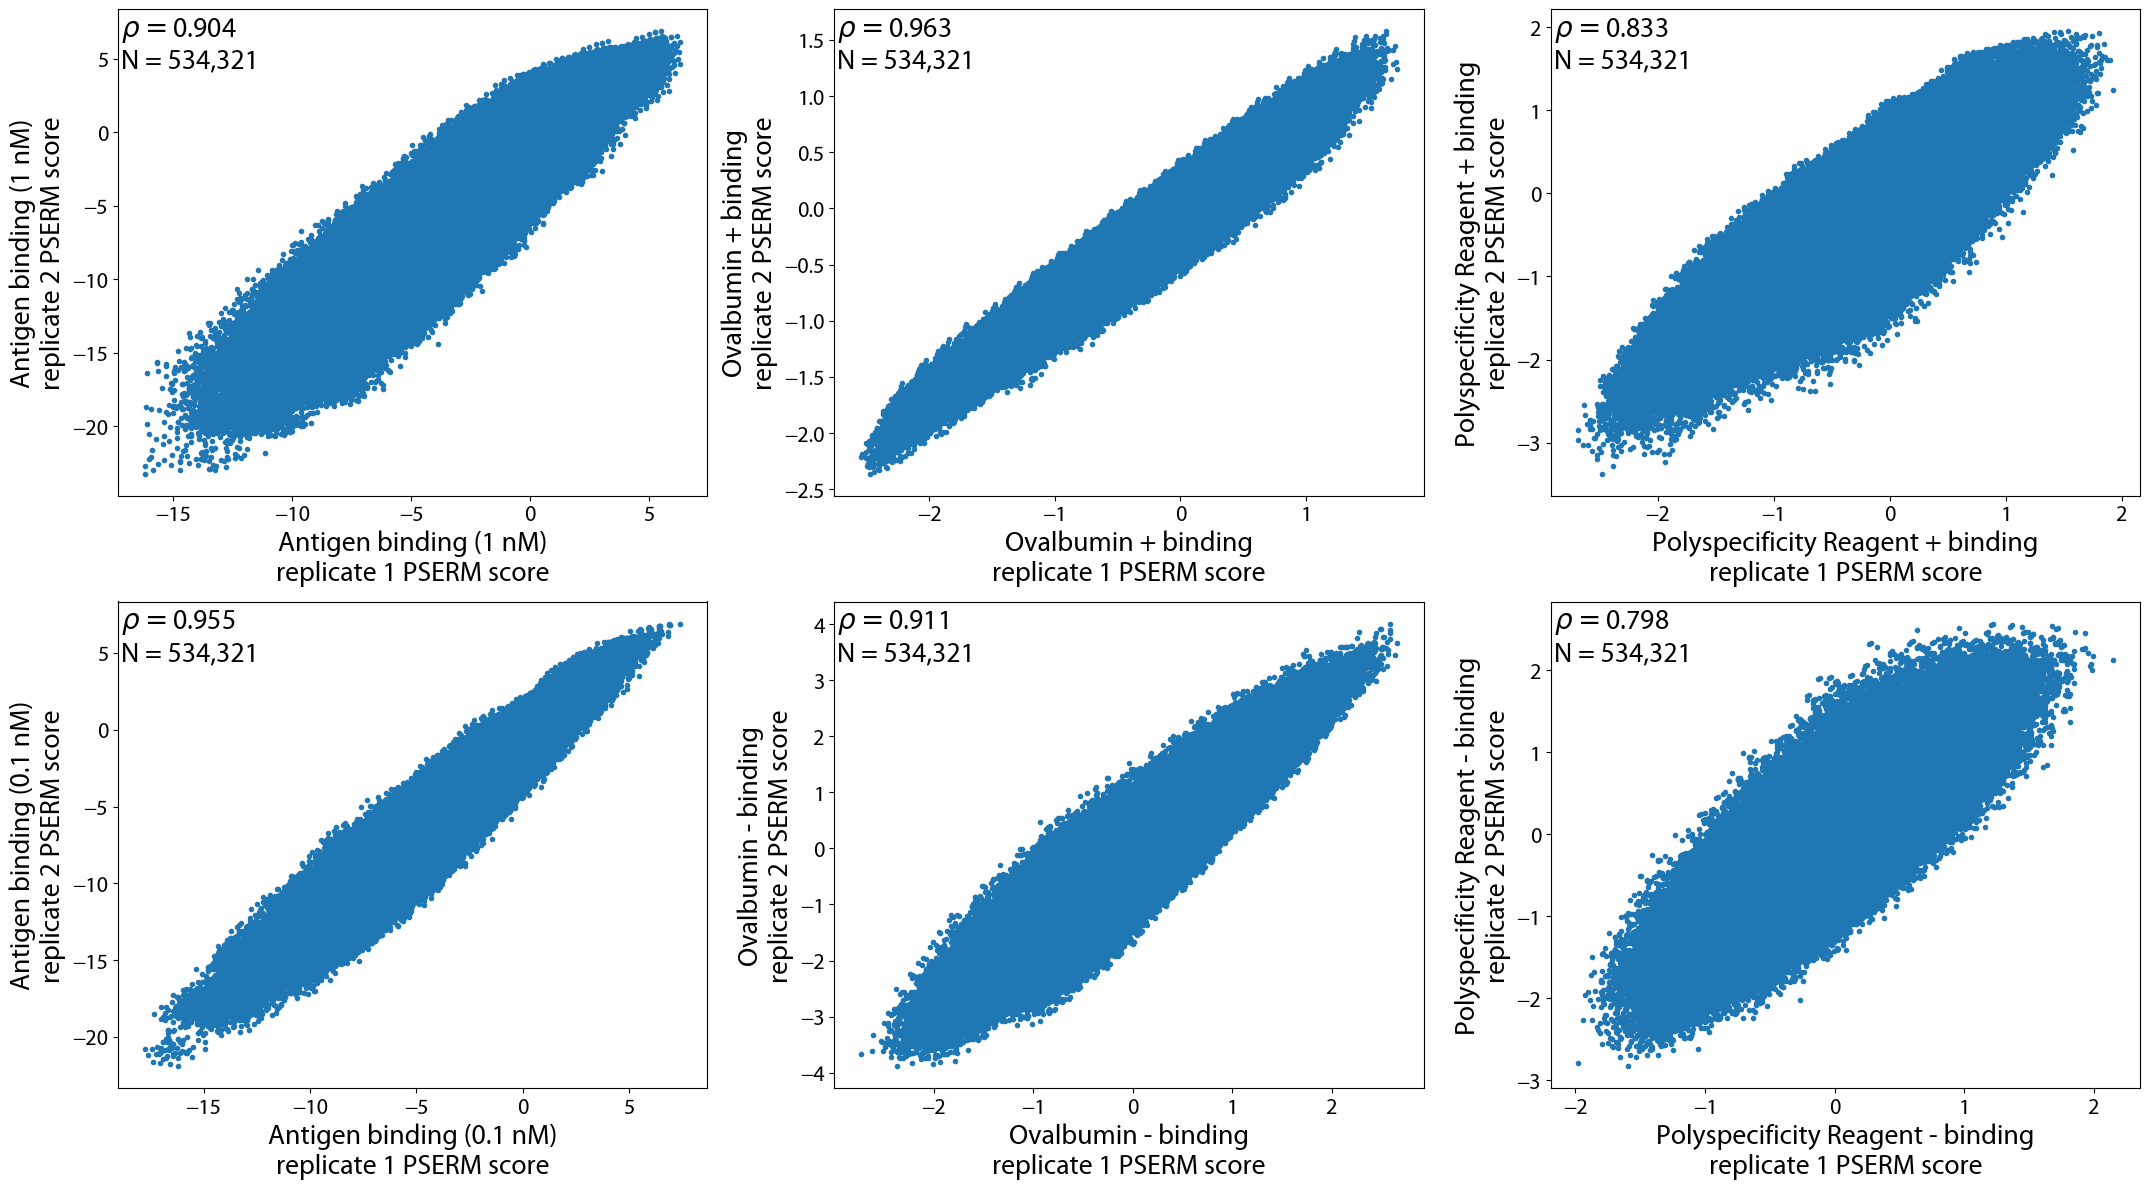

In [13]:
common_seqs_p1 = list(set(p1_data_r1.scores.index).intersection(set(p1_data_r2.scores.index)))

fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

##############Ag plots##############
p1_r1_PSERM, p1_p1_PSERM = spearmanr(
    p1_data_r1.scores.loc[common_seqs_p1, 'Ag1_P PSERM Score'], 
    p1_data_r2.scores.loc[common_seqs_p1, 'Ag1_P PSERM Score'],
    nan_policy='omit')
axs[0, 0].plot(p1_data_r1.scores.loc[common_seqs_p1, 'Ag1_P PSERM Score'], p1_data_r2.scores.loc[common_seqs_p1, 'Ag1_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r1_PSERM:.3}' + f'\nN = {len(common_seqs_p1):,}')

axs[0, 0].set_xlabel('Antigen binding (1 nM)\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen binding (1 nM)\n'+r'replicate 2 PSERM score', fontproperties = prop)

p1_r2_PSERM, p1_p2_PSERM = spearmanr(
    p1_data_r1.scores.loc[common_seqs_p1, 'Ag01_P PSERM Score'], 
    p1_data_r2.scores.loc[common_seqs_p1, 'Ag01_P PSERM Score'],
    nan_policy='omit')
axs[1, 0].plot(p1_data_r1.scores.loc[common_seqs_p1, 'Ag01_P PSERM Score'], p1_data_r2.scores.loc[common_seqs_p1, 'Ag01_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r2_PSERM:.3}' + f'\nN = {len(common_seqs_p1):,}')

axs[1, 0].set_xlabel('Antigen binding (0.1 nM)\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen binding (0.1 nM)\n'+r'replicate 2 PSERM score', fontproperties = prop)

##############Ova plots##############
p1_r3_PSERM, p1_p3_PSERM = spearmanr(
    p1_data_r1.scores.loc[common_seqs_p1, 'Ova_P PSERM Score'], 
    p1_data_r2.scores.loc[common_seqs_p1, 'Ova_P PSERM Score'],
    nan_policy='omit')
axs[0, 1].plot(p1_data_r1.scores.loc[common_seqs_p1, 'Ova_P PSERM Score'], p1_data_r2.scores.loc[common_seqs_p1, 'Ova_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r3_PSERM:.3}' + f'\nN = {len(common_seqs_p1):,}')

axs[0, 1].set_xlabel('Ovalbumin + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 1].set_ylabel('Ovalbumin + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p1_r4_PSERM, p1_p4_PSERM = spearmanr(
    p1_data_r1.scores.loc[common_seqs_p1, 'Ova_N PSERM Score'], 
    p1_data_r2.scores.loc[common_seqs_p1, 'Ova_N PSERM Score'],
    nan_policy='omit')
axs[1, 1].plot(p1_data_r1.scores.loc[common_seqs_p1, 'Ova_N PSERM Score'], p1_data_r2.scores.loc[common_seqs_p1, 'Ova_N PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r4_PSERM:.3}' + f'\nN = {len(common_seqs_p1):,}')

axs[1, 1].set_xlabel('Ovalbumin - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 1].set_ylabel('Ovalbumin - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

##############PSR plots##############
p1_r5_PSERM, p1_p5_PSERM = spearmanr(
    p1_data_r1.scores.loc[common_seqs_p1, 'PSR_P PSERM Score'], 
    p1_data_r2.scores.loc[common_seqs_p1, 'PSR_P PSERM Score'],
    nan_policy='omit')
axs[0, 2].plot(p1_data_r1.scores.loc[common_seqs_p1, 'PSR_P PSERM Score'], p1_data_r2.scores.loc[common_seqs_p1, 'PSR_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r5_PSERM:.3}' + f'\nN = {len(common_seqs_p1):,}')

axs[0, 2].set_xlabel('Polyspecificity Reagent + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 2].set_ylabel('Polyspecificity Reagent + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p1_r6_PSERM, p1_p6_PSERM = spearmanr(
    p1_data_r1.scores.loc[common_seqs_p1, 'PSR_N PSERM Score'], 
    p1_data_r2.scores.loc[common_seqs_p1, 'PSR_N PSERM Score'],
    nan_policy='omit')
axs[1, 2].plot(p1_data_r1.scores.loc[common_seqs_p1, 'PSR_N PSERM Score'], p1_data_r2.scores.loc[common_seqs_p1, 'PSR_N PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r6_PSERM:.3}' + f'\nN = {len(common_seqs_p1):,}')

axs[1, 2].set_xlabel('Polyspecificity Reagent - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 2].set_ylabel('Polyspecificity Reagent - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

#Format ticklabels and add legend
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)
plt.tight_layout()

plt.show()

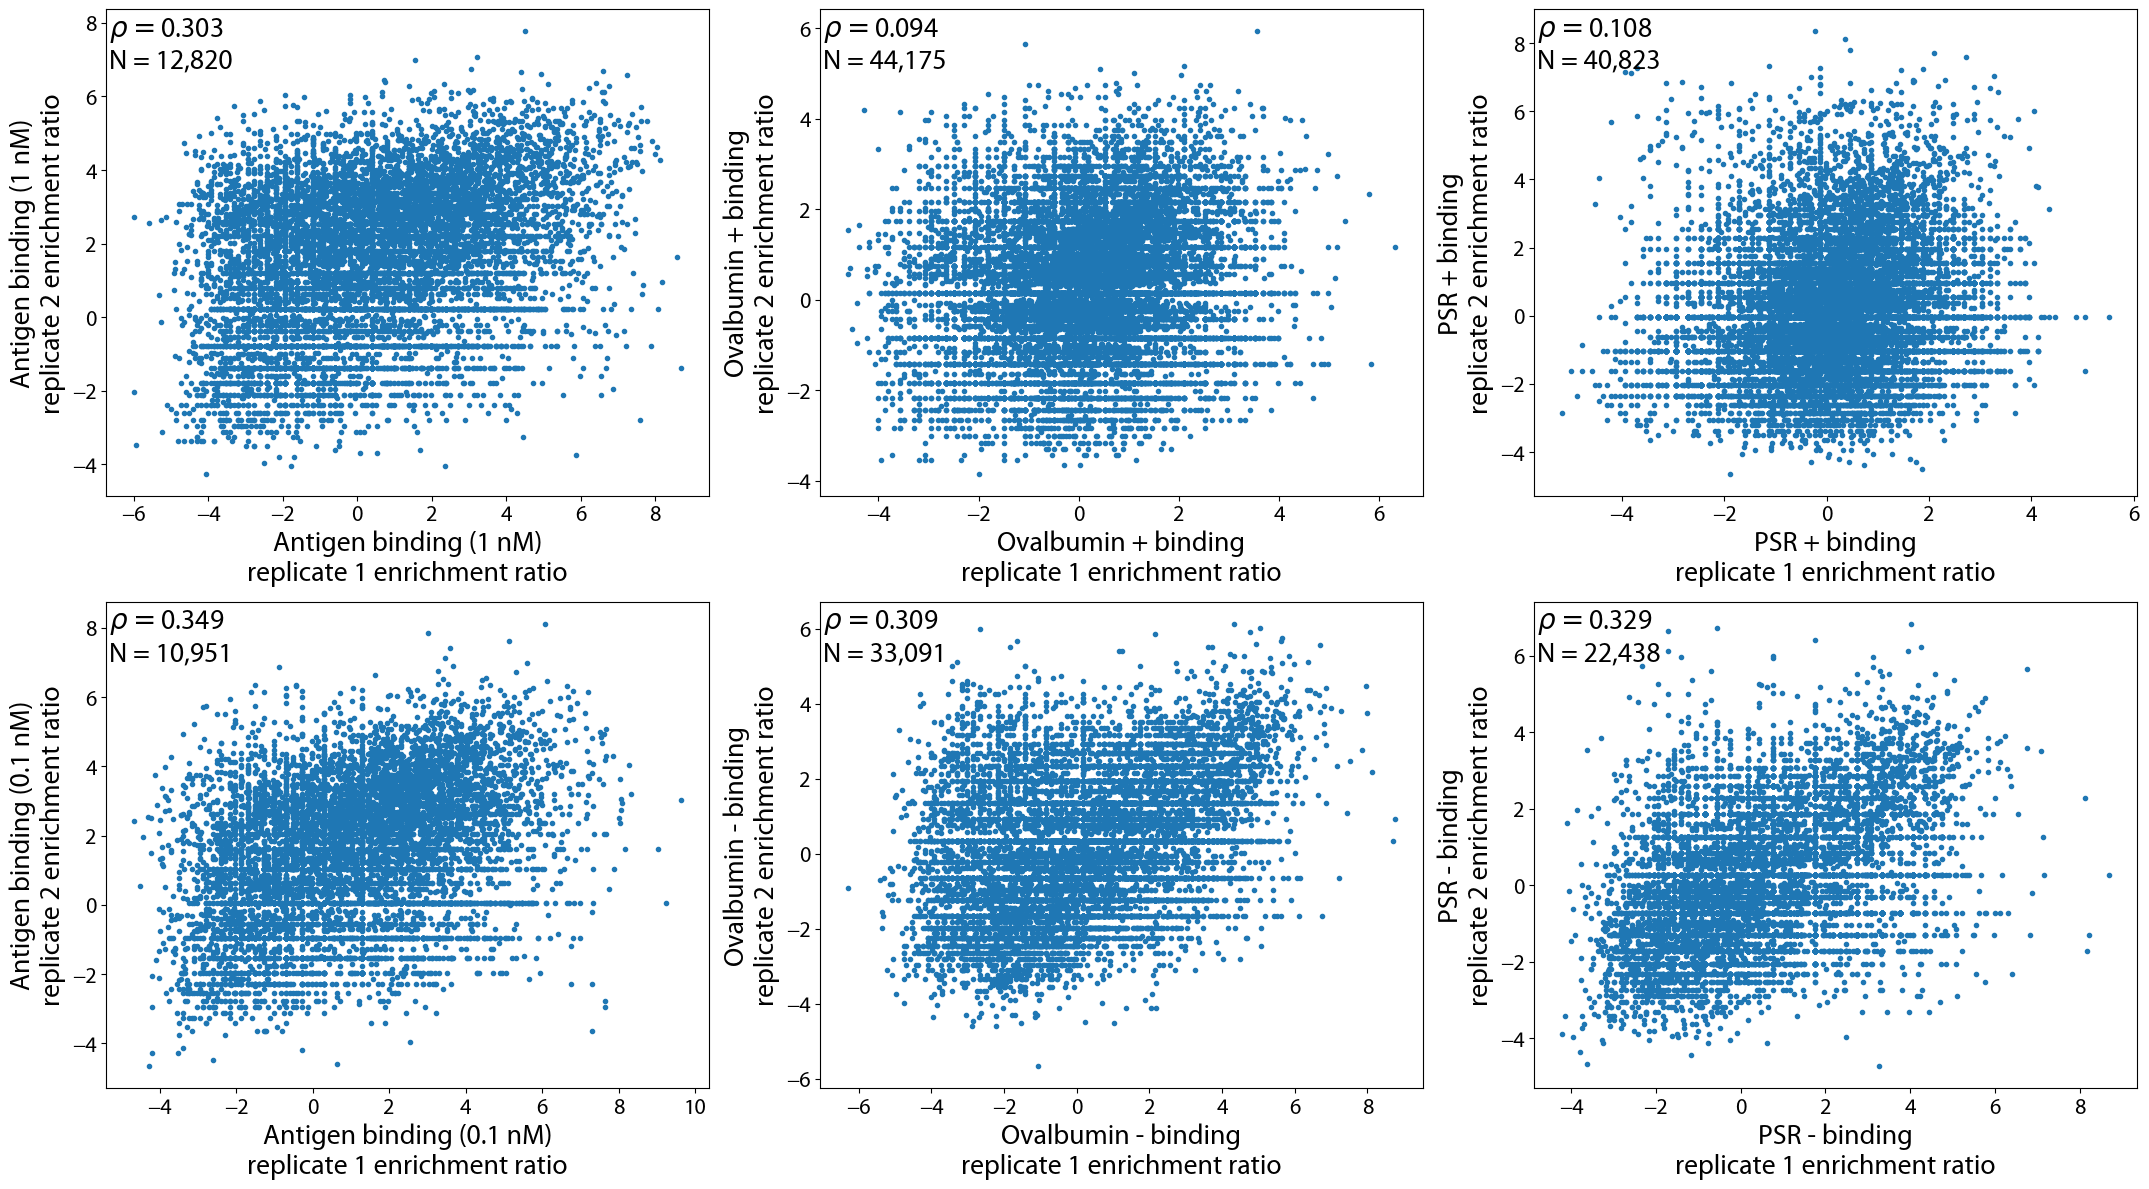

In [9]:
fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

##############Ag plots##############
p1_r1_clones = set(p1_data_r1.D[(p1_data_r1.D['Input'] > 0) & (p1_data_r1.D['Ag1_P'] > 0)].index)
p1_r2_clones = set(p1_data_r2.D[(p1_data_r2.D['Input'] > 0) & (p1_data_r2.D['Ag1_P'] > 0)].index)

p1_er_clones_s1 = list(p1_r1_clones.intersection(p1_r2_clones))

p1_r1_er, p1_p1_er = spearmanr(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s1, 'Ag1_P'] / p1_data_r1.D.loc[p1_er_clones_s1, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s1, 'Ag1_P'] / p1_data_r2.D.loc[p1_er_clones_s1, 'Input']))
axs[0, 0].plot(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s1, 'Ag1_P'] / p1_data_r1.D.loc[p1_er_clones_s1, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s1, 'Ag1_P'] / p1_data_r2.D.loc[p1_er_clones_s1, 'Input']), 
    '.', label = r'$\rho =$' + f'{p1_r1_er:.3}' + f'\nN = {len(p1_er_clones_s1):,}')

axs[0, 0].set_xlabel('Antigen binding (1 nM)\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen binding (1 nM)\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

p1_r1_clones = set(p1_data_r1.D[(p1_data_r1.D['Input'] > 0) & (p1_data_r1.D['Ag01_P'] > 0)].index)
p1_r2_clones = set(p1_data_r2.D[(p1_data_r2.D['Input'] > 0) & (p1_data_r2.D['Ag01_P'] > 0)].index)

p1_er_clones_s2 = list(p1_r1_clones.intersection(p1_r2_clones))

p1_r2_er, p1_p2_er = spearmanr(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s2, 'Ag01_P'] / p1_data_r1.D.loc[p1_er_clones_s2, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s2, 'Ag01_P'] / p1_data_r2.D.loc[p1_er_clones_s2, 'Input']))
axs[1, 0].plot(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s2, 'Ag01_P'] / p1_data_r1.D.loc[p1_er_clones_s2, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s2, 'Ag01_P'] / p1_data_r2.D.loc[p1_er_clones_s2, 'Input']), 
    '.', label = r'$\rho =$' + f'{p1_r2_er:.3}' + f'\nN = {len(p1_er_clones_s2):,}')

axs[1, 0].set_xlabel('Antigen binding (0.1 nM)\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen binding (0.1 nM)\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

##############Ova plots##############
p1_r1_clones = set(p1_data_r1.D[(p1_data_r1.D['Input'] > 0) & (p1_data_r1.D['Ova_P'] > 0)].index)
p1_r2_clones = set(p1_data_r2.D[(p1_data_r2.D['Input'] > 0) & (p1_data_r2.D['Ova_P'] > 0)].index)

p1_er_clones_s3 = list(p1_r1_clones.intersection(p1_r2_clones))

p1_r3_er, p1_p3_er = spearmanr(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s3, 'Ova_P'] / p1_data_r1.D.loc[p1_er_clones_s3, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s3, 'Ova_P'] / p1_data_r2.D.loc[p1_er_clones_s3, 'Input']))
axs[0, 1].plot(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s3, 'Ova_P'] / p1_data_r1.D.loc[p1_er_clones_s3, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s3, 'Ova_P'] / p1_data_r2.D.loc[p1_er_clones_s3, 'Input']), 
    '.', label = r'$\rho =$' + f'{p1_r3_er:.3}' + f'\nN = {len(p1_er_clones_s3):,}')

axs[0, 1].set_xlabel('Ovalbumin + binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 1].set_ylabel('Ovalbumin + binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

p1_r1_clones = set(p1_data_r1.D[(p1_data_r1.D['Input'] > 0) & (p1_data_r1.D['Ova_N'] > 0)].index)
p1_r2_clones = set(p1_data_r2.D[(p1_data_r2.D['Input'] > 0) & (p1_data_r2.D['Ova_N'] > 0)].index)

p1_er_clones_s4 = list(p1_r1_clones.intersection(p1_r2_clones))

p1_r4_er, p1_p4_er = spearmanr(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s4, 'Ova_N'] / p1_data_r1.D.loc[p1_er_clones_s4, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s4, 'Ova_N'] / p1_data_r2.D.loc[p1_er_clones_s4, 'Input']))
axs[1, 1].plot(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s4, 'Ova_N'] / p1_data_r1.D.loc[p1_er_clones_s4, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s4, 'Ova_N'] / p1_data_r2.D.loc[p1_er_clones_s4, 'Input']), 
    '.', label = r'$\rho =$' + f'{p1_r4_er:.3}' + f'\nN = {len(p1_er_clones_s4):,}')

axs[1, 1].set_xlabel('Ovalbumin - binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 1].set_ylabel('Ovalbumin - binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

##############PSR plots##############
p1_r1_clones = set(p1_data_r1.D[(p1_data_r1.D['Input'] > 0) & (p1_data_r1.D['PSR_P'] > 0)].index)
p1_r2_clones = set(p1_data_r2.D[(p1_data_r2.D['Input'] > 0) & (p1_data_r2.D['PSR_P'] > 0)].index)

p1_er_clones_s5 = list(p1_r1_clones.intersection(p1_r2_clones))

p1_r5_er, p1_p3_er = spearmanr(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s5, 'PSR_P'] / p1_data_r1.D.loc[p1_er_clones_s5, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s5, 'PSR_P'] / p1_data_r2.D.loc[p1_er_clones_s5, 'Input']))
axs[0, 2].plot(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s5, 'PSR_P'] / p1_data_r1.D.loc[p1_er_clones_s5, 'Input']),
    np.log2(p1_data_r2.D.loc[p1_er_clones_s5, 'PSR_P'] / p1_data_r2.D.loc[p1_er_clones_s5, 'Input']), 
    '.', label = r'$\rho =$' + f'{p1_r5_er:.3}' + f'\nN = {len(p1_er_clones_s5):,}')

axs[0, 2].set_xlabel('PSR + binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 2].set_ylabel('PSR + binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

p1_r1_clones = set(p1_data_r1.D[(p1_data_r1.D['Input'] > 0) & (p1_data_r1.D['PSR_N'] > 0)].index)
p1_r2_clones = set(p1_data_r2.D[(p1_data_r2.D['Input'] > 0) & (p1_data_r2.D['PSR_N'] > 0)].index)

p1_er_clones_s6 = list(p1_r1_clones.intersection(p1_r2_clones))

p1_r6_er, p1_p4_er = spearmanr(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s6, 'PSR_N'] / p1_data_r1.D.loc[p1_er_clones_s6, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s6, 'PSR_N'] / p1_data_r2.D.loc[p1_er_clones_s6, 'Input']))
axs[1, 2].plot(
    np.log2(p1_data_r1.D.loc[p1_er_clones_s6, 'PSR_N'] / p1_data_r1.D.loc[p1_er_clones_s6, 'Input']), 
    np.log2(p1_data_r2.D.loc[p1_er_clones_s6, 'PSR_N'] / p1_data_r2.D.loc[p1_er_clones_s6, 'Input']), 
    '.', label = r'$\rho =$' + f'{p1_r6_er:.3}' + f'\nN = {len(p1_er_clones_s6):,}')

axs[1, 2].set_xlabel('PSR - binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 2].set_ylabel('PSR - binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)


#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()

plt.show()


## PSERM on ER clone set.

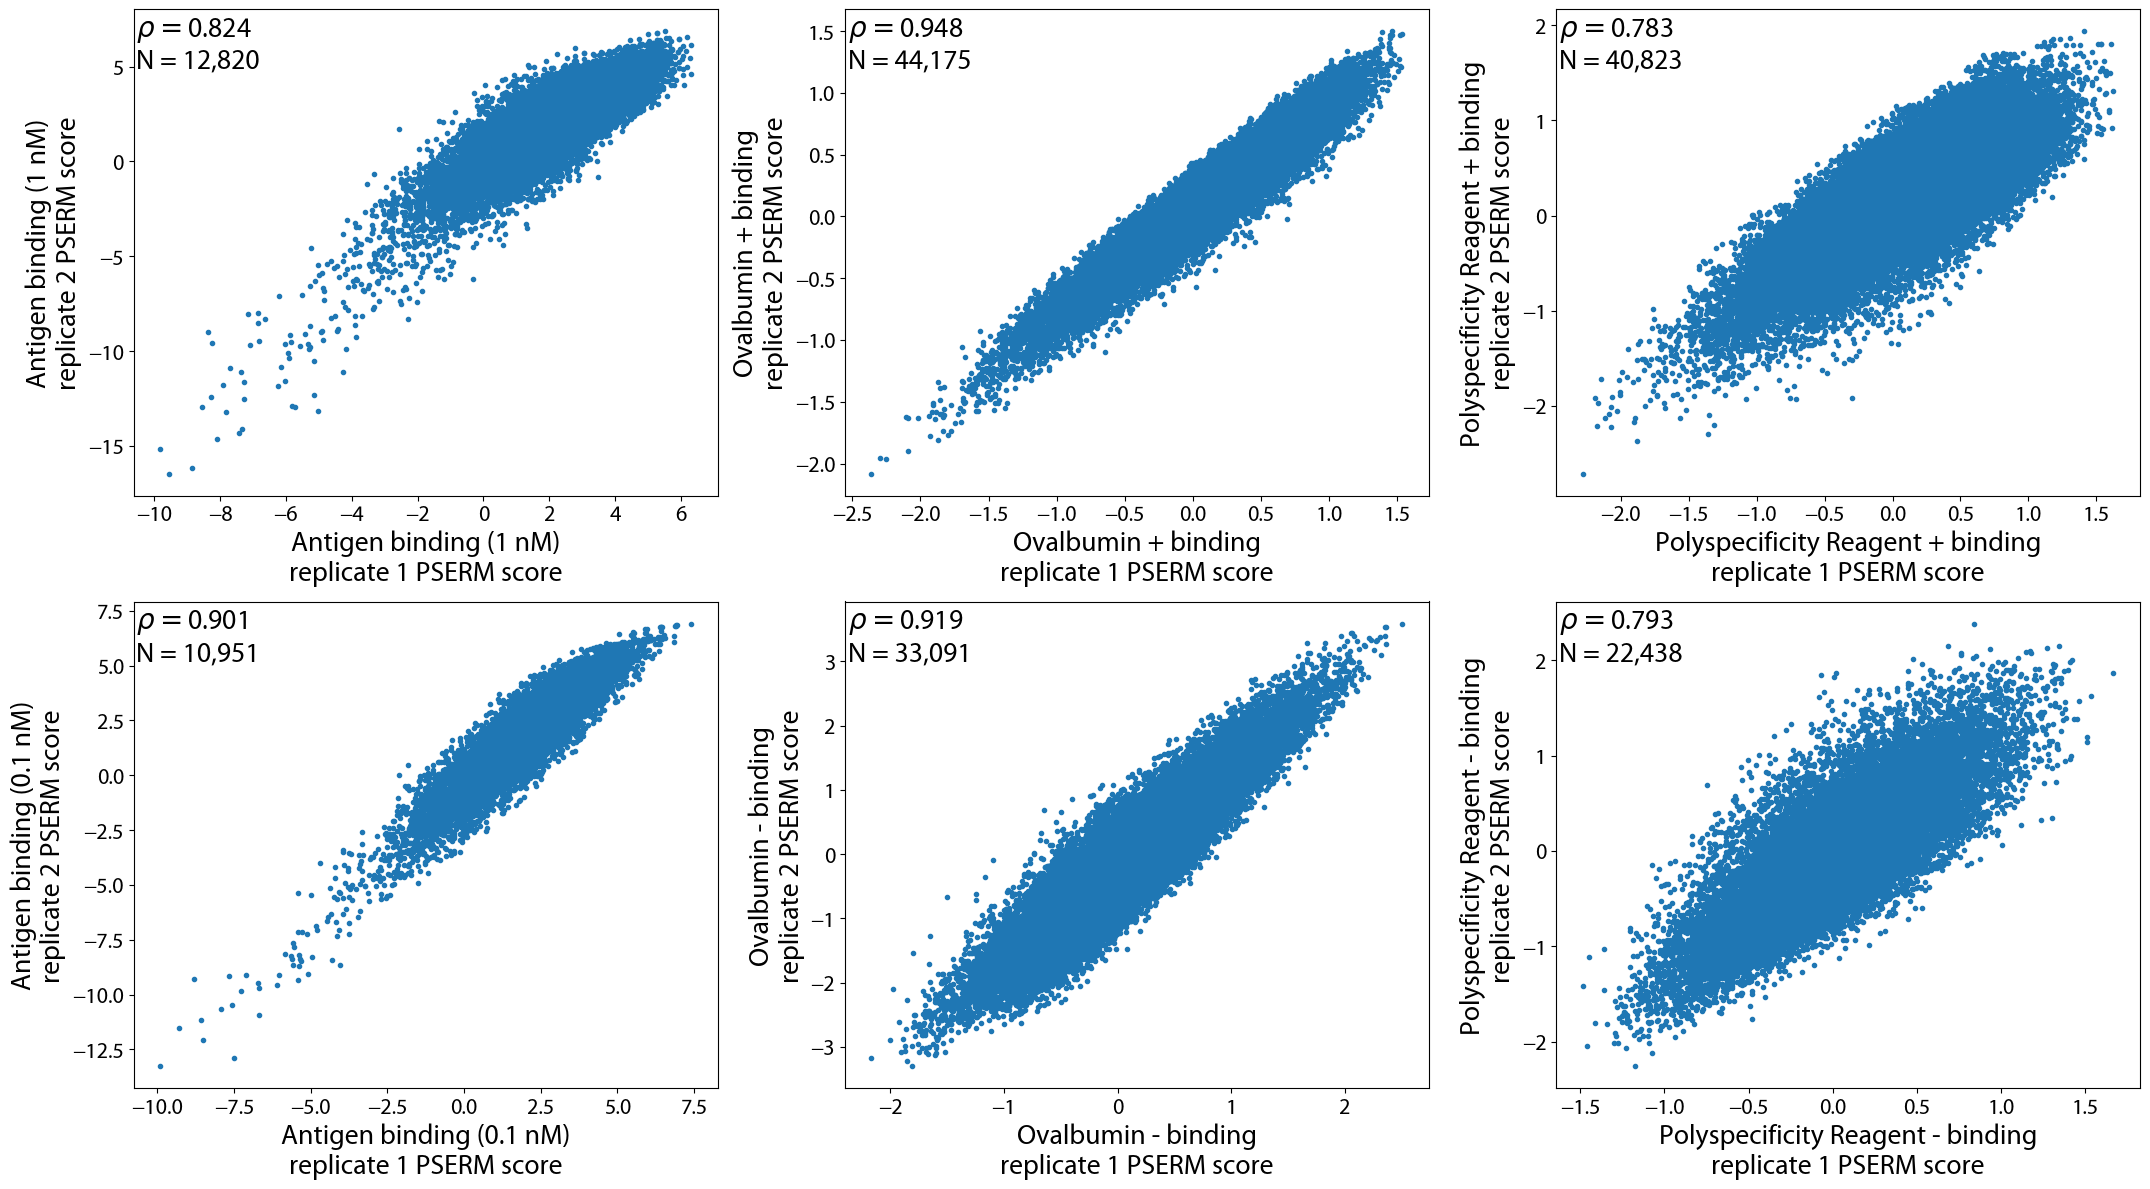

In [12]:
fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

##############Ag plots##############
p1_r1_PSERM_er, p1_p1_PSERM_er = spearmanr(
    p1_data_r1.scores.loc[p1_er_clones_s1, 'Ag1_P PSERM Score'], 
    p1_data_r2.scores.loc[p1_er_clones_s1, 'Ag1_P PSERM Score'],
    nan_policy='omit')
axs[0, 0].plot(p1_data_r1.scores.loc[p1_er_clones_s1, 'Ag1_P PSERM Score'], p1_data_r2.scores.loc[p1_er_clones_s1, 'Ag1_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r1_PSERM_er:.3}' + f'\nN = {len(p1_er_clones_s1):,}')

axs[0, 0].set_xlabel('Antigen binding (1 nM)\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen binding (1 nM)\n'+r'replicate 2 PSERM score', fontproperties = prop)

p1_r2_PSERM_er, p1_p2_PSERM_er = spearmanr(
    p1_data_r1.scores.loc[p1_er_clones_s2, 'Ag01_P PSERM Score'], 
    p1_data_r2.scores.loc[p1_er_clones_s2, 'Ag01_P PSERM Score'],
    nan_policy='omit')
axs[1, 0].plot(p1_data_r1.scores.loc[p1_er_clones_s2, 'Ag01_P PSERM Score'], p1_data_r2.scores.loc[p1_er_clones_s2, 'Ag01_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r2_PSERM_er:.3}' + f'\nN = {len(p1_er_clones_s2):,}')

axs[1, 0].set_xlabel('Antigen binding (0.1 nM)\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen binding (0.1 nM)\n'+r'replicate 2 PSERM score', fontproperties = prop)

##############Ova plots##############
p1_r3_PSERM_er, p1_p3_PSERM_er = spearmanr(
    p1_data_r1.scores.loc[p1_er_clones_s3, 'Ova_P PSERM Score'], 
    p1_data_r2.scores.loc[p1_er_clones_s3, 'Ova_P PSERM Score'],
    nan_policy='omit')
axs[0, 1].plot(p1_data_r1.scores.loc[p1_er_clones_s3, 'Ova_P PSERM Score'], p1_data_r2.scores.loc[p1_er_clones_s3, 'Ova_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r3_PSERM_er:.3}' + f'\nN = {len(p1_er_clones_s3):,}')

axs[0, 1].set_xlabel('Ovalbumin + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 1].set_ylabel('Ovalbumin + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p1_r4_PSERM_er, p1_p4_PSERM_er = spearmanr(
    p1_data_r1.scores.loc[p1_er_clones_s4, 'Ova_N PSERM Score'], 
    p1_data_r2.scores.loc[p1_er_clones_s4, 'Ova_N PSERM Score'],
    nan_policy='omit')
axs[1, 1].plot(p1_data_r1.scores.loc[p1_er_clones_s4, 'Ova_N PSERM Score'], p1_data_r2.scores.loc[p1_er_clones_s4, 'Ova_N PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r4_PSERM_er:.3}' + f'\nN = {len(p1_er_clones_s4):,}')

axs[1, 1].set_xlabel('Ovalbumin - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 1].set_ylabel('Ovalbumin - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

##############PSR plots##############
p1_r5_PSERM_er, p1_p5_PSERM_er = spearmanr(
    p1_data_r1.scores.loc[p1_er_clones_s5, 'PSR_P PSERM Score'], 
    p1_data_r2.scores.loc[p1_er_clones_s5, 'PSR_P PSERM Score'],
    nan_policy='omit')
axs[0, 2].plot(p1_data_r1.scores.loc[p1_er_clones_s5, 'PSR_P PSERM Score'], p1_data_r2.scores.loc[p1_er_clones_s5, 'PSR_P PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r5_PSERM_er:.3}' + f'\nN = {len(p1_er_clones_s5):,}')

axs[0, 2].set_xlabel('Polyspecificity Reagent + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 2].set_ylabel('Polyspecificity Reagent + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p1_r6_PSERM_er, p1_p6_PSERM_er = spearmanr(
    p1_data_r1.scores.loc[p1_er_clones_s6, 'PSR_N PSERM Score'], 
    p1_data_r2.scores.loc[p1_er_clones_s6, 'PSR_N PSERM Score'],
    nan_policy='omit')
axs[1, 2].plot(p1_data_r1.scores.loc[p1_er_clones_s6, 'PSR_N PSERM Score'], p1_data_r2.scores.loc[p1_er_clones_s6, 'PSR_N PSERM Score'],
    '.', label = r'$\rho =$' + f'{p1_r6_PSERM_er:.3}' + f'\nN = {len(p1_er_clones_s6):,}')

axs[1, 2].set_xlabel('Polyspecificity Reagent - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 2].set_ylabel('Polyspecificity Reagent - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

#Format ticklabels and add legend
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)
plt.tight_layout()

plt.show()

In [59]:
print(f"Average count of a mutation in rep 1 Input\t {round(p1_data_r1.Counts['Input'].mean().mean(), 1)}")
print(f"Average count of a ER sequence in rep 1 Input\t {round(p1_data_r1.counts.loc[p1_er_clones_s1, 'Input'].mean(),1)}")
print(f"Average count of sequence in rep 1 Input\t {round(p1_data_r1.counts['Input'].mean(), 1)}")
print()
print(f"Average count of a mutation in rep 1 Output\t {round(p1_data_r1.Counts['Ag01_P'].mean().mean(),1)}")
print(f"Average count of a ER sequence in rep 1 Output\t {round(p1_data_r1.counts.loc[p1_er_clones_s1, 'Ag01_P'].mean(), 1)}")
print(f"Average count of sequence in rep 1 Output\t {round(p1_data_r1.counts['Ag01_P'].mean(), 1)}")
print()
print(f"Average count of a mutation in rep 2 Input\t {round(p1_data_r2.Counts['Input'].mean().mean(), 1)}")
print(f"Average count of a ER sequence in rep 2 Input\t {round(p1_data_r2.counts.loc[p1_er_clones_s1, 'Input'].mean(), 1)}")
print(f"Average count of sequence in rep 2 Input\t {round(p1_data_r2.counts['Input'].mean(), 1)}")
print()
print(f"Average count of a mutation in rep 2 Output\t {round(p1_data_r2.Counts['Ag01_P'].mean().mean(), 1)}")
print(f"Average count of a ER sequence in rep 2 Output\t {round(p1_data_r2.counts.loc[p1_er_clones_s1, 'Ag01_P'].mean(), 1)}")
print(f"Average count of sequence in rep 2 Output\t {round(p1_data_r2.counts['Ag01_P'].mean(), 1)}")

Average count of a mutation in rep 1 Input	 55595.0
Average count of a ER sequence in rep 1 Input	 10.4
Average count of sequence in rep 1 Input	 1.1

Average count of a mutation in rep 1 Output	 22510.7
Average count of a ER sequence in rep 1 Output	 25.0
Average count of sequence in rep 1 Output	 0.4

Average count of a mutation in rep 2 Input	 20837.4
Average count of a ER sequence in rep 2 Input	 4.2
Average count of sequence in rep 2 Input	 0.6

Average count of a mutation in rep 2 Output	 20211.5
Average count of a ER sequence in rep 2 Output	 23.8
Average count of sequence in rep 2 Output	 0.6


In [73]:
print(f"Minimum count of a mutation in rep 1 Input\t {round(p1_data_r1.Counts['Input'].replace(0, np.inf).min().min(), 1)}")
print(f"Minimum count of a ER sequence in rep 1 Input\t {round(p1_data_r1.counts.loc[p1_er_clones_s1, 'Input'].replace(0, np.inf).min(),1)}")
print(f"Minimum count of sequence in rep 1 Input\t {round(p1_data_r1.counts['Input'].replace(0, np.inf).min(), 1)}")
print()
print(f"Minimum count of a mutation in rep 1 Output\t {round(p1_data_r1.Counts['Ag01_P'].replace(0, np.inf).min().min(),1)}")
print(f"Minimum count of a ER sequence in rep 1 Output\t {round(p1_data_r1.counts.loc[p1_er_clones_s1, 'Ag01_P'].replace(0, np.inf).min(), 1)}")
print(f"Minimum count of sequence in rep 1 Output\t {round(p1_data_r1.counts['Ag01_P'].replace(0, np.inf).min(), 1)}")
print()
print(f"Minimum count of a mutation in rep 2 Input\t {round(p1_data_r2.Counts['Input'].replace(0, np.inf).min().min(), 1)}")
print(f"Minimum count of a ER sequence in rep 2 Input\t {round(p1_data_r2.counts.loc[p1_er_clones_s1, 'Input'].replace(0, np.inf).min(), 1)}")
print(f"Minimum count of sequence in rep 2 Input\t {round(p1_data_r2.counts['Input'].replace(0, np.inf).min(), 1)}")
print()
print(f"Minimum count of a mutation in rep 2 Output\t {round(p1_data_r2.Counts['Ag01_P'].replace(0, np.inf).min().min(), 1)}")
print(f"Minimum count of a ER sequence in rep 2 Output\t {round(p1_data_r2.counts.loc[p1_er_clones_s1, 'Ag01_P'].replace(0, np.inf).min(), 1)}")
print(f"Minimum count of sequence in rep 2 Output\t {round(p1_data_r2.counts['Ag01_P'].replace(0, np.inf).min(), 1)}")

Minimum count of a mutation in rep 1 Input	 78165.0
Minimum count of a ER sequence in rep 1 Input	 1.0
Minimum count of sequence in rep 1 Input	 1.0

Minimum count of a mutation in rep 1 Output	 2012.0
Minimum count of a ER sequence in rep 1 Output	 1.0
Minimum count of sequence in rep 1 Output	 1.0

Minimum count of a mutation in rep 2 Input	 29269.0
Minimum count of a ER sequence in rep 2 Input	 1.0
Minimum count of sequence in rep 2 Input	 1.0

Minimum count of a mutation in rep 2 Output	 2770.0
Minimum count of a ER sequence in rep 2 Output	 1.0
Minimum count of sequence in rep 2 Output	 1.0


In [74]:
p1_data_r1.Counts['Input']

0       1       2       3       4       5       6       7
F  172288       0       0       0       0  125288       0  127420
W       0       0       0       0       0       0  146116       0
Y  326838       0       0       0       0  108505       0  137101
P       0       0       0       0       0       0       0       0
M       0       0       0       0       0       0       0       0
I       0       0       0       0       0       0       0       0
L       0       0       0       0       0       0  152514       0
V  228064       0       0       0       0  105983  202519  257771
A  121767  176767  192214  120629  149479  300517  194297  222046
G       0  120033  349154  307414  401821       0  263430       0
C       0       0       0       0       0       0       0       0
S  128579       0       0       0  195674  293934  153023  140277
T       0  140247  147508  122358   78165       0       0       0
N       0       0       0       0   94142       0       0       0
Q       0       0       0       0       0       0       0       0
D  134363       0       0       0  192618  177672       0  227284
E       0  122620  148516  133982       0       0       0       0
H       0       0       0       0       0       0       0       0
K       0  215922  105418  161170       0       0       0       0
R       0  336310  169089  266346       0       0       0       0

# Project 2

## Setups and data processing

In [15]:
# Project 2 NGS_round_data setups
p2_wt = 'IDDLYPYWYG'

p2_muts_no_wt = {
    0: ['V'],
    1: ['F', 'K', 'R', 'P', 'Y'],
    2: ['T', 'H', 'K', 'N', 'Y'],
    3: ['R', 'S', 'G'],
    4: ['K'],
    5: ['R', 'G'],
    6: ['K', 'R', 'D', 'E', 'H'],
    7: ['K', 'A', 'D', 'E', 'H'],
    8: ['S', 'Q', 'D', 'E'],
    9: ['A', 'S', 'T', 'K']
}

p2_r1 = NGS_round_data(
    Round = 1, 
    sequence_type = 'mutations', 
    samples = ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], 
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_2/Rep_1/VH/', 
    wild_type = p2_wt,
    mutations_dict = p2_muts_no_wt
)

p2_r2 = NGS_round_data(
    Round = 1, 
    sequence_type = 'mutations', 
    samples = ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], 
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_2/Rep_2/VH/', 
    wild_type = p2_wt,
    mutations_dict = p2_muts_no_wt
)

['Mutation_1001.csv', 'Mutation_1002.csv', 'Mutation_1003.csv', 'Mutation_1004.csv', 'Mutation_1005.csv', 'Mutation_1006.csv', 'Mutation_1007.csv']
['Mutation_1001.csv', 'Mutation_1002.csv', 'Mutation_1003.csv', 'Mutation_1004.csv', 'Mutation_1005.csv', 'Mutation_1006.csv', 'Mutation_1007.csv']


In [16]:
p2_clone_set_trimmed_r1 = generate_clone_set(p2_r1, ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'])
p2_clone_set_trimmed_r2 = generate_clone_set(p2_r2, ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'])

p2_data_r1 = ngs_analysis([p2_r1], ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], clone_set = p2_clone_set_trimmed_r1)
p2_data_r2 = ngs_analysis([p2_r2], ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], clone_set = p2_clone_set_trimmed_r2)

p2_data_r1.generate_D()
p2_data_r2.generate_D()

100%|██████████| 2360974/2360974 [00:04<00:00, 507994.71it/s]


In [17]:
for sample in tqdm.tqdm(p2_data_r1.samples):
    p2_data_r1.generate_PSSM(sample)
    p2_data_r2.generate_PSSM(sample)

for sample in tqdm.tqdm(p2_data_r1.samples):
    if sample != 'Input':
        p2_data_r1.generate_PSERM(In_sample = 'Input', Out_sample = sample)
        p2_data_r2.generate_PSERM(In_sample = 'Input', Out_sample = sample)

  0%|          | 0/7 [00:00<?, ?it/s]

Generating MSA.


100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


Generating MSA.


100%|██████████| 7/7 [00:00<00:00, 2472.43it/s]


In [18]:
p2_data_r1.score_all_clones_mp(method = 'PSERM')
p2_data_r2.score_all_clones_mp(method = 'PSERM')

Done in 9.03 minutes
Done in 7.37 minutes


## Plots

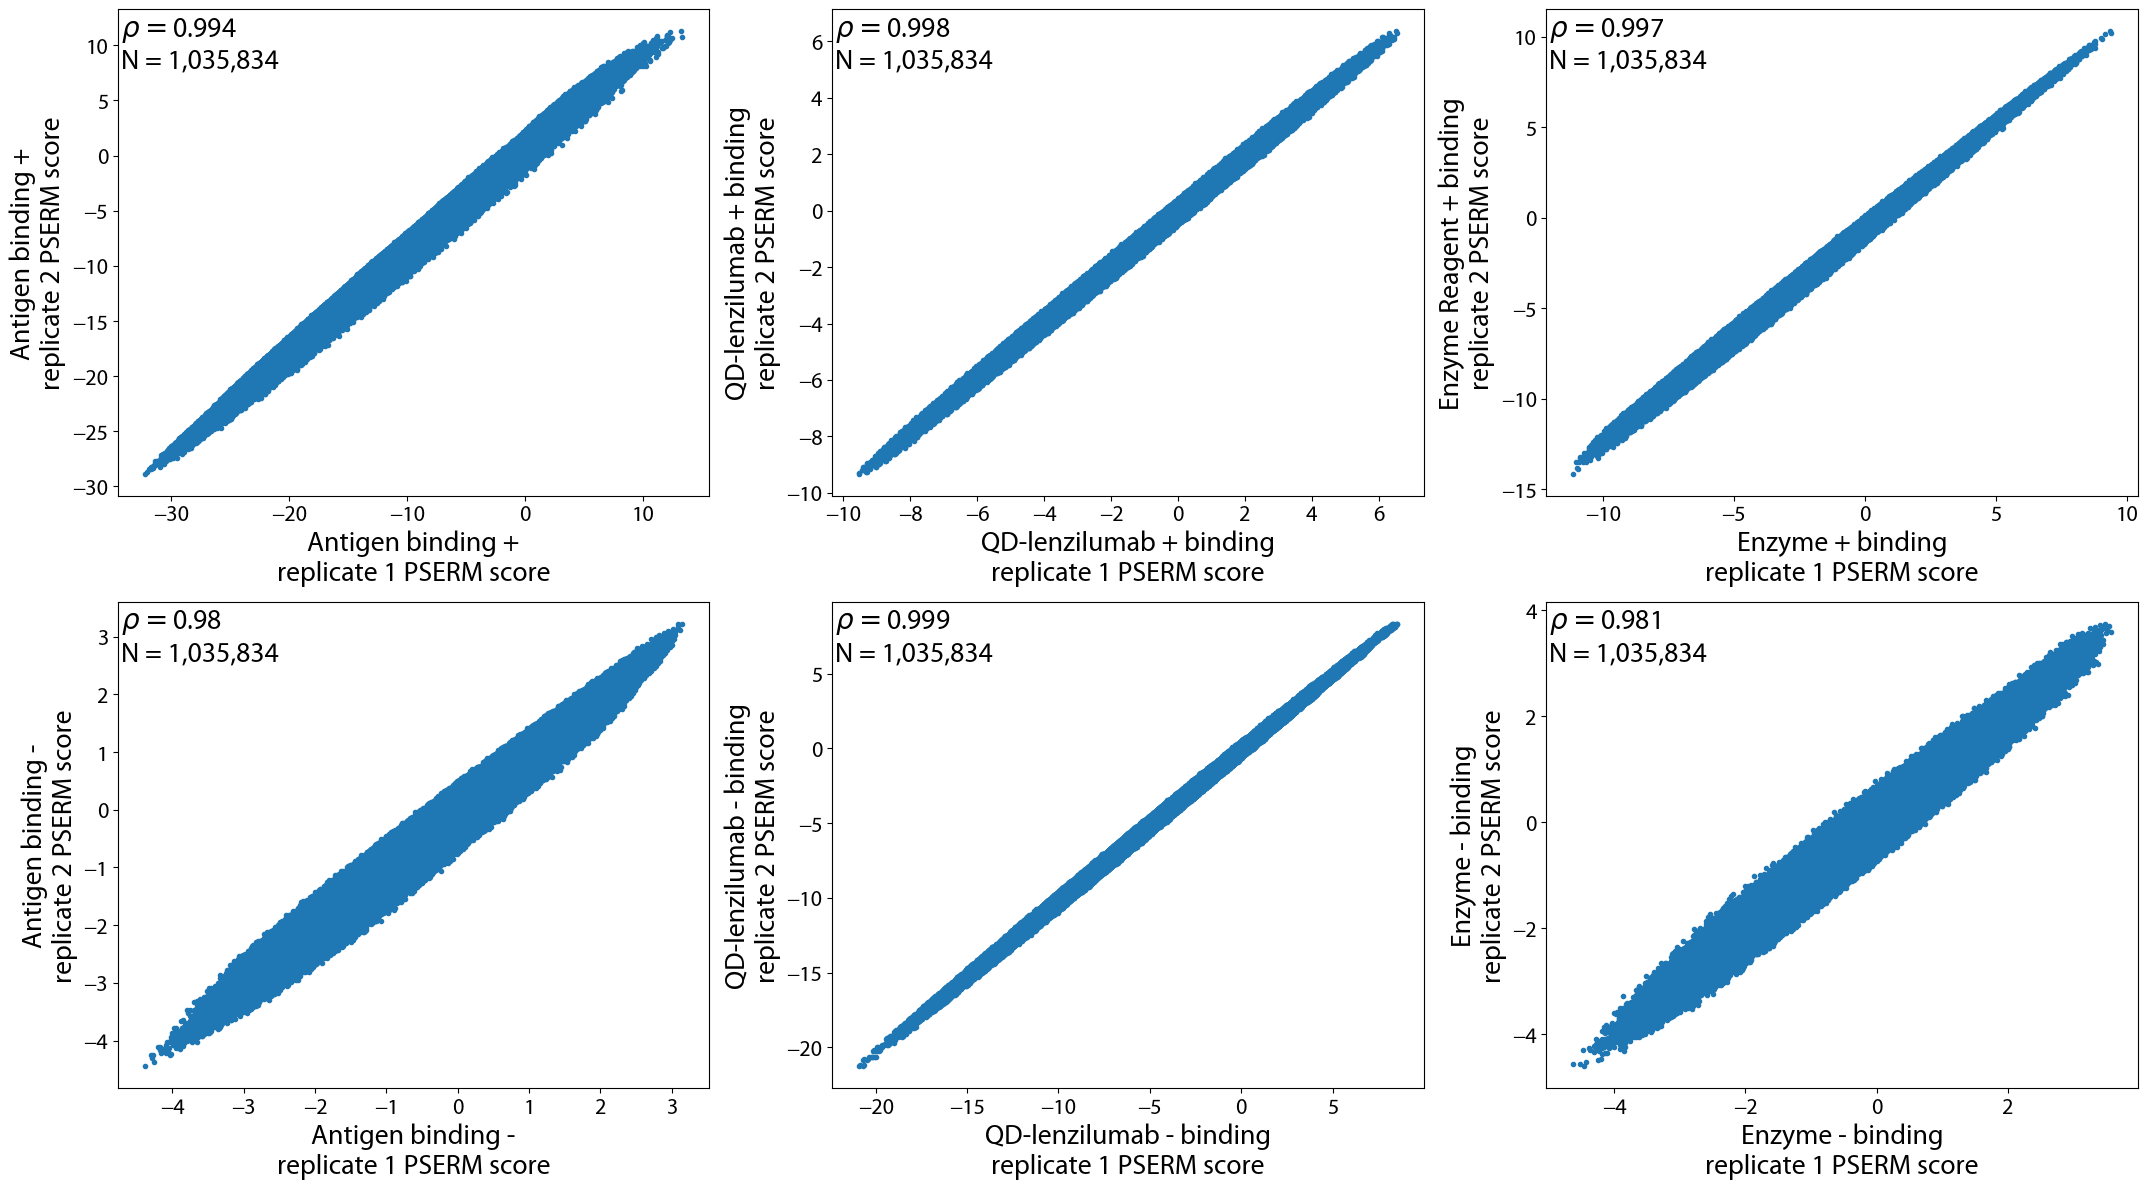

In [19]:
common_seqs_p2 = list(set(p2_data_r1.scores.index).intersection(set(p2_data_r2.scores.index)))

fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

#Antigen PSERMS
p2_r1_PSERM, p2_p1_PSERM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'AgP PSERM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'AgP PSERM Score'],
    nan_policy='omit')
axs[0, 0].plot(p2_data_r1.scores.loc[common_seqs_p2, 'AgP PSERM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'AgP PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r1_PSERM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[0, 0].set_xlabel('Antigen binding +\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen binding +\n'+r'replicate 2 PSERM score', fontproperties = prop)

p2_r2_PSERM, p2_p2_PSERM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'AgN PSERM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'AgN PSERM Score'],
    nan_policy='omit')
axs[1, 0].plot(p2_data_r1.scores.loc[common_seqs_p2, 'AgN PSERM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'AgN PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r2_PSERM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[1, 0].set_xlabel('Antigen binding -\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen binding -\n'+r'replicate 2 PSERM score', fontproperties = prop)

#Ova PSERMS
p2_r3_PSERM, p2_p3_PSERM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'QDP PSERM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'QDP PSERM Score'],
    nan_policy='omit')
axs[0, 1].plot(p2_data_r1.scores.loc[common_seqs_p2, 'QDP PSERM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'QDP PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r3_PSERM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[0, 1].set_xlabel('QD-lenzilumab + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 1].set_ylabel('QD-lenzilumab + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p2_r4_PSERM, p2_p4_PSERM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'QDN PSERM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'QDN PSERM Score'],
    nan_policy='omit')
axs[1, 1].plot(p2_data_r1.scores.loc[common_seqs_p2, 'QDN PSERM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'QDN PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r4_PSERM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[1, 1].set_xlabel('QD-lenzilumab - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 1].set_ylabel('QD-lenzilumab - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

#PSR PSERMS
p2_r5_PSERM, p2_p5_PSERM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'EP PSERM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'EP PSERM Score'],
    nan_policy='omit')
axs[0, 2].plot(p2_data_r1.scores.loc[common_seqs_p2, 'EP PSERM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'EP PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r5_PSERM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[0, 2].set_xlabel('Enzyme + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 2].set_ylabel('Enzyme Reagent + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p2_r6_PSERM, p2_p6_PSERM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'EN PSERM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'EN PSERM Score'],
    nan_policy='omit')
axs[1, 2].plot(p2_data_r1.scores.loc[common_seqs_p2, 'EN PSERM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'EN PSERM Score'],
    '.', label =  r'$\rho =$' + f'{p2_r6_PSERM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[1, 2].set_xlabel('Enzyme - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 2].set_ylabel('Enzyme - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)
        
plt.tight_layout()

plt.show()

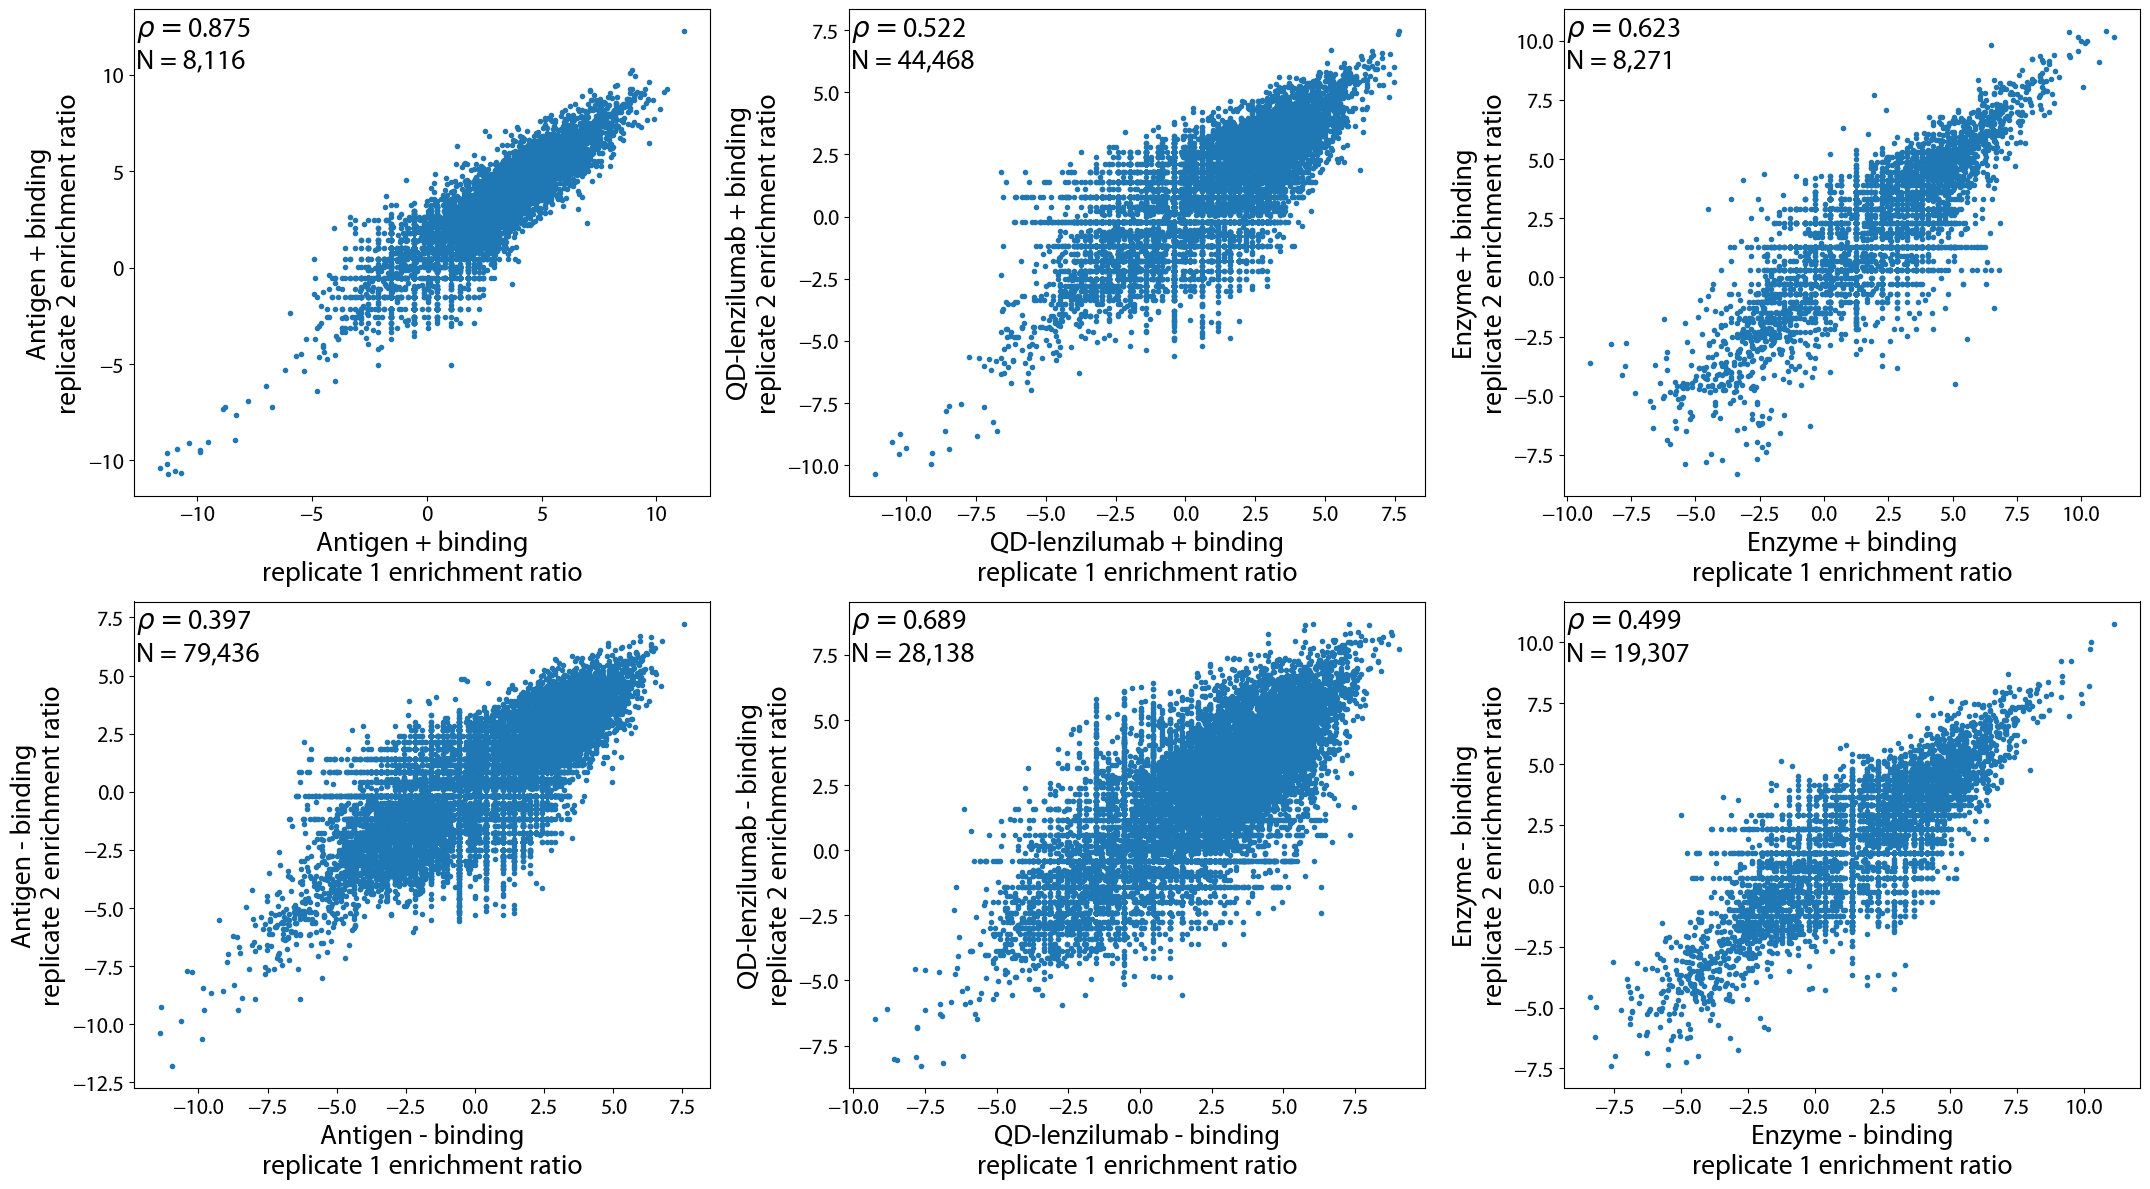

In [20]:
fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

##############Ag plots##############
p2_r1_clones = set(p2_data_r1.D[(p2_data_r1.D['Input'] > 0) & (p2_data_r1.D['AgP'] > 0)].index)
p2_r2_clones = set(p2_data_r2.D[(p2_data_r2.D['Input'] > 0) & (p2_data_r2.D['AgP'] > 0)].index)

p2_er_clones_s1 = list(p2_r1_clones.intersection(p2_r2_clones))

p2_r1_er, p2_p1_er = spearmanr(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s1, 'AgP'] / p2_data_r1.D.loc[p2_er_clones_s1, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s1, 'AgP'] / p2_data_r2.D.loc[p2_er_clones_s1, 'Input']))
axs[0, 0].plot(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s1, 'AgP'] / p2_data_r1.D.loc[p2_er_clones_s1, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s1, 'AgP'] / p2_data_r2.D.loc[p2_er_clones_s1, 'Input']), 
    '.', label = r'$\rho =$' + f'{p2_r1_er:.3}' + f'\nN = {len(p2_er_clones_s1):,}')

axs[0, 0].set_xlabel('Antigen + binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen + binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

p2_r1_clones = set(p2_data_r1.D[(p2_data_r1.D['Input'] > 0) & (p2_data_r1.D['AgN'] > 0)].index)
p2_r2_clones = set(p2_data_r2.D[(p2_data_r2.D['Input'] > 0) & (p2_data_r2.D['AgN'] > 0)].index)

p2_er_clones_s2 = list(p2_r1_clones.intersection(p2_r2_clones))

p2_r2_er, p2_p2_er = spearmanr(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s2, 'AgN'] / p2_data_r1.D.loc[p2_er_clones_s2, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s2, 'AgN'] / p2_data_r2.D.loc[p2_er_clones_s2, 'Input']))
axs[1, 0].plot(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s2, 'AgN'] / p2_data_r1.D.loc[p2_er_clones_s2, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s2, 'AgN'] / p2_data_r2.D.loc[p2_er_clones_s2, 'Input']), 
    '.', label = r'$\rho =$' + f'{p2_r2_er:.3}' + f'\nN = {len(p2_er_clones_s2):,}')

axs[1, 0].set_xlabel('Antigen - binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen - binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

##############Ova plots##############
p2_r1_clones = set(p2_data_r1.D[(p2_data_r1.D['Input'] > 0) & (p2_data_r1.D['QDP'] > 0)].index)
p2_r2_clones = set(p2_data_r2.D[(p2_data_r2.D['Input'] > 0) & (p2_data_r2.D['QDP'] > 0)].index)

p2_er_clones_s3 = list(p2_r1_clones.intersection(p2_r2_clones))

p2_r3_er, p2_p3_er = spearmanr(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s3, 'QDP'] / p2_data_r1.D.loc[p2_er_clones_s3, 'Input']),
    np.log2(p2_data_r2.D.loc[p2_er_clones_s3, 'QDP'] / p2_data_r2.D.loc[p2_er_clones_s3, 'Input']))
axs[0, 1].plot(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s3, 'QDP'] / p2_data_r1.D.loc[p2_er_clones_s3, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s3, 'QDP'] / p2_data_r2.D.loc[p2_er_clones_s3, 'Input']), 
    '.', label = r'$\rho =$' + f'{p2_r3_er:.3}' + f'\nN = {len(p2_er_clones_s3):,}')

axs[0, 1].set_xlabel('QD-lenzilumab + binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 1].set_ylabel('QD-lenzilumab + binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

p2_r1_clones = set(p2_data_r1.D[(p2_data_r1.D['Input'] > 0) & (p2_data_r1.D['QDN'] > 0)].index)
p2_r2_clones = set(p2_data_r2.D[(p2_data_r2.D['Input'] > 0) & (p2_data_r2.D['QDN'] > 0)].index)

p2_er_clones_s4 = list(p2_r1_clones.intersection(p2_r2_clones))

p2_r4_er, p2_p4_er = spearmanr(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s4, 'QDN'] / p2_data_r1.D.loc[p2_er_clones_s4, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s4, 'QDN'] / p2_data_r2.D.loc[p2_er_clones_s4, 'Input']))
axs[1, 1].plot(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s4, 'QDN'] / p2_data_r1.D.loc[p2_er_clones_s4, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s4, 'QDN'] / p2_data_r2.D.loc[p2_er_clones_s4, 'Input']), 
    '.', label = r'$\rho =$' + f'{p2_r4_er:.3}' + f'\nN = {len(p2_er_clones_s4):,}')

axs[1, 1].set_xlabel('QD-lenzilumab - binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 1].set_ylabel('QD-lenzilumab - binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

##############Enzyme plots##############
p2_r1_clones = set(p2_data_r1.D[(p2_data_r1.D['Input'] > 0) & (p2_data_r1.D['EP'] > 0)].index)
p2_r2_clones = set(p2_data_r2.D[(p2_data_r2.D['Input'] > 0) & (p2_data_r2.D['EP'] > 0)].index)

p2_er_clones_s5 = list(p2_r1_clones.intersection(p2_r2_clones))

p2_r5_er, p2_p3_er = spearmanr(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s5, 'EP'] / p2_data_r1.D.loc[p2_er_clones_s5, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s5, 'EP'] / p2_data_r2.D.loc[p2_er_clones_s5, 'Input']))
axs[0, 2].plot(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s5, 'EP'] / p2_data_r1.D.loc[p2_er_clones_s5, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s5, 'EP'] / p2_data_r2.D.loc[p2_er_clones_s5, 'Input']), 
    '.', label = r'$\rho =$' + f'{p2_r5_er:.3}' + f'\nN = {len(p2_er_clones_s5):,}')

axs[0, 2].set_xlabel('Enzyme + binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 2].set_ylabel('Enzyme + binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)

p2_r1_clones = set(p2_data_r1.D[(p2_data_r1.D['Input'] > 0) & (p2_data_r1.D['EN'] > 0)].index)
p2_r2_clones = set(p2_data_r2.D[(p2_data_r2.D['Input'] > 0) & (p2_data_r2.D['EN'] > 0)].index)

p2_er_clones_s6 = list(p2_r1_clones.intersection(p2_r2_clones))

p2_r6_er, p2_p4_er = spearmanr(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s6, 'EN'] / p2_data_r1.D.loc[p2_er_clones_s6, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s6, 'EN'] / p2_data_r2.D.loc[p2_er_clones_s6, 'Input']))
axs[1, 2].plot(
    np.log2(p2_data_r1.D.loc[p2_er_clones_s6, 'EN'] / p2_data_r1.D.loc[p2_er_clones_s6, 'Input']), 
    np.log2(p2_data_r2.D.loc[p2_er_clones_s6, 'EN'] / p2_data_r2.D.loc[p2_er_clones_s6, 'Input']), 
    '.', label = r'$\rho =$' + f'{p2_r6_er:.3}' + f'\nN = {len(p2_er_clones_s6):,}')

axs[1, 2].set_xlabel('Enzyme - binding\n'+r'replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 2].set_ylabel('Enzyme - binding\n'+r'replicate 2 enrichment ratio', fontproperties = prop)


#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()

plt.show()


## PSSM

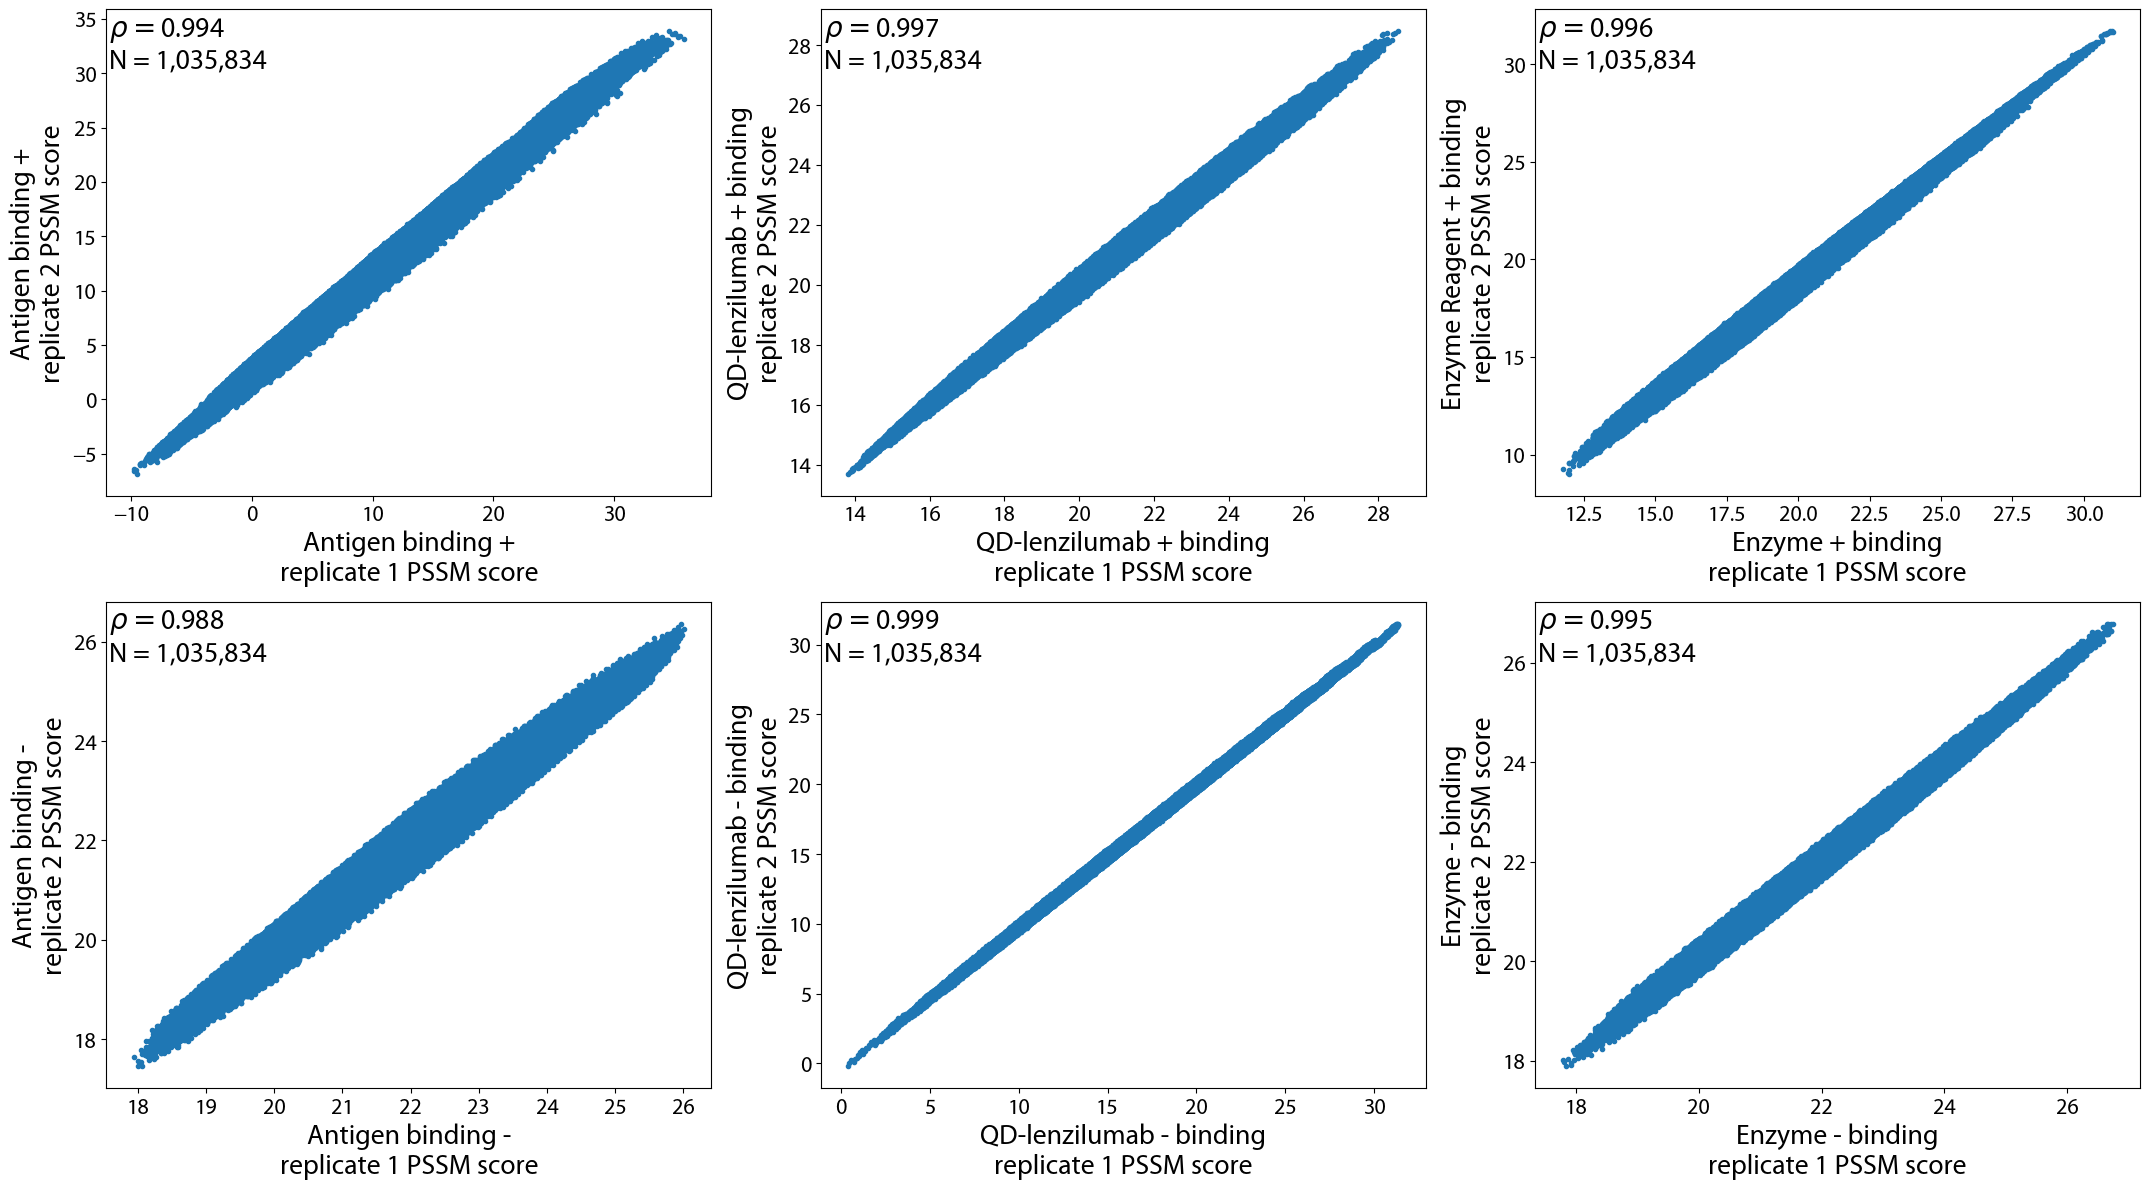

In [6]:
fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

#Antigen PSSMS
p2_r1_PSSM, p2_p1_PSSM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'AgP PSSM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'AgP PSSM Score'],
    nan_policy='omit')
axs[0, 0].plot(p2_data_r1.scores.loc[common_seqs_p2, 'AgP PSSM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'AgP PSSM Score'],
    '.', label = r'$\rho =$' + f'{p2_r1_PSSM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[0, 0].set_xlabel('Antigen binding +\n'+r'replicate 1 PSSM score', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen binding +\n'+r'replicate 2 PSSM score', fontproperties = prop)

p2_r2_PSSM, p2_p2_PSSM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'AgN PSSM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'AgN PSSM Score'],
    nan_policy='omit')
axs[1, 0].plot(p2_data_r1.scores.loc[common_seqs_p2, 'AgN PSSM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'AgN PSSM Score'],
    '.', label = r'$\rho =$' + f'{p2_r2_PSSM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[1, 0].set_xlabel('Antigen binding -\n'+r'replicate 1 PSSM score', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen binding -\n'+r'replicate 2 PSSM score', fontproperties = prop)

#Ova PSSMS
p2_r3_PSSM, p2_p3_PSSM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'QDP PSSM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'QDP PSSM Score'],
    nan_policy='omit')
axs[0, 1].plot(p2_data_r1.scores.loc[common_seqs_p2, 'QDP PSSM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'QDP PSSM Score'],
    '.', label = r'$\rho =$' + f'{p2_r3_PSSM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[0, 1].set_xlabel('QD-lenzilumab + binding\n'+r'replicate 1 PSSM score', fontproperties = prop)
axs[0, 1].set_ylabel('QD-lenzilumab + binding\n'+r'replicate 2 PSSM score', fontproperties = prop)

p2_r4_PSSM, p2_p4_PSSM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'QDN PSSM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'QDN PSSM Score'],
    nan_policy='omit')
axs[1, 1].plot(p2_data_r1.scores.loc[common_seqs_p2, 'QDN PSSM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'QDN PSSM Score'],
    '.', label = r'$\rho =$' + f'{p2_r4_PSSM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[1, 1].set_xlabel('QD-lenzilumab - binding\n'+r'replicate 1 PSSM score', fontproperties = prop)
axs[1, 1].set_ylabel('QD-lenzilumab - binding\n'+r'replicate 2 PSSM score', fontproperties = prop)

#PSR PSSMS
p2_r5_PSSM, p2_p5_PSSM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'EP PSSM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'EP PSSM Score'],
    nan_policy='omit')
axs[0, 2].plot(p2_data_r1.scores.loc[common_seqs_p2, 'EP PSSM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'EP PSSM Score'],
    '.', label = r'$\rho =$' + f'{p2_r5_PSSM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[0, 2].set_xlabel('Enzyme + binding\n'+r'replicate 1 PSSM score', fontproperties = prop)
axs[0, 2].set_ylabel('Enzyme Reagent + binding\n'+r'replicate 2 PSSM score', fontproperties = prop)

p2_r6_PSSM, p2_p6_PSSM = spearmanr(
    p2_data_r1.scores.loc[common_seqs_p2, 'EN PSSM Score'], 
    p2_data_r2.scores.loc[common_seqs_p2, 'EN PSSM Score'],
    nan_policy='omit')
axs[1, 2].plot(p2_data_r1.scores.loc[common_seqs_p2, 'EN PSSM Score'], p2_data_r2.scores.loc[common_seqs_p2, 'EN PSSM Score'],
    '.', label =  r'$\rho =$' + f'{p2_r6_PSSM:.3}' + f'\nN = {len(common_seqs_p2):,}')

axs[1, 2].set_xlabel('Enzyme - binding\n'+r'replicate 1 PSSM score', fontproperties = prop)
axs[1, 2].set_ylabel('Enzyme - binding\n'+r'replicate 2 PSSM score', fontproperties = prop)

#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)
        
plt.tight_layout()

plt.show()

## PSERM on ER clone set

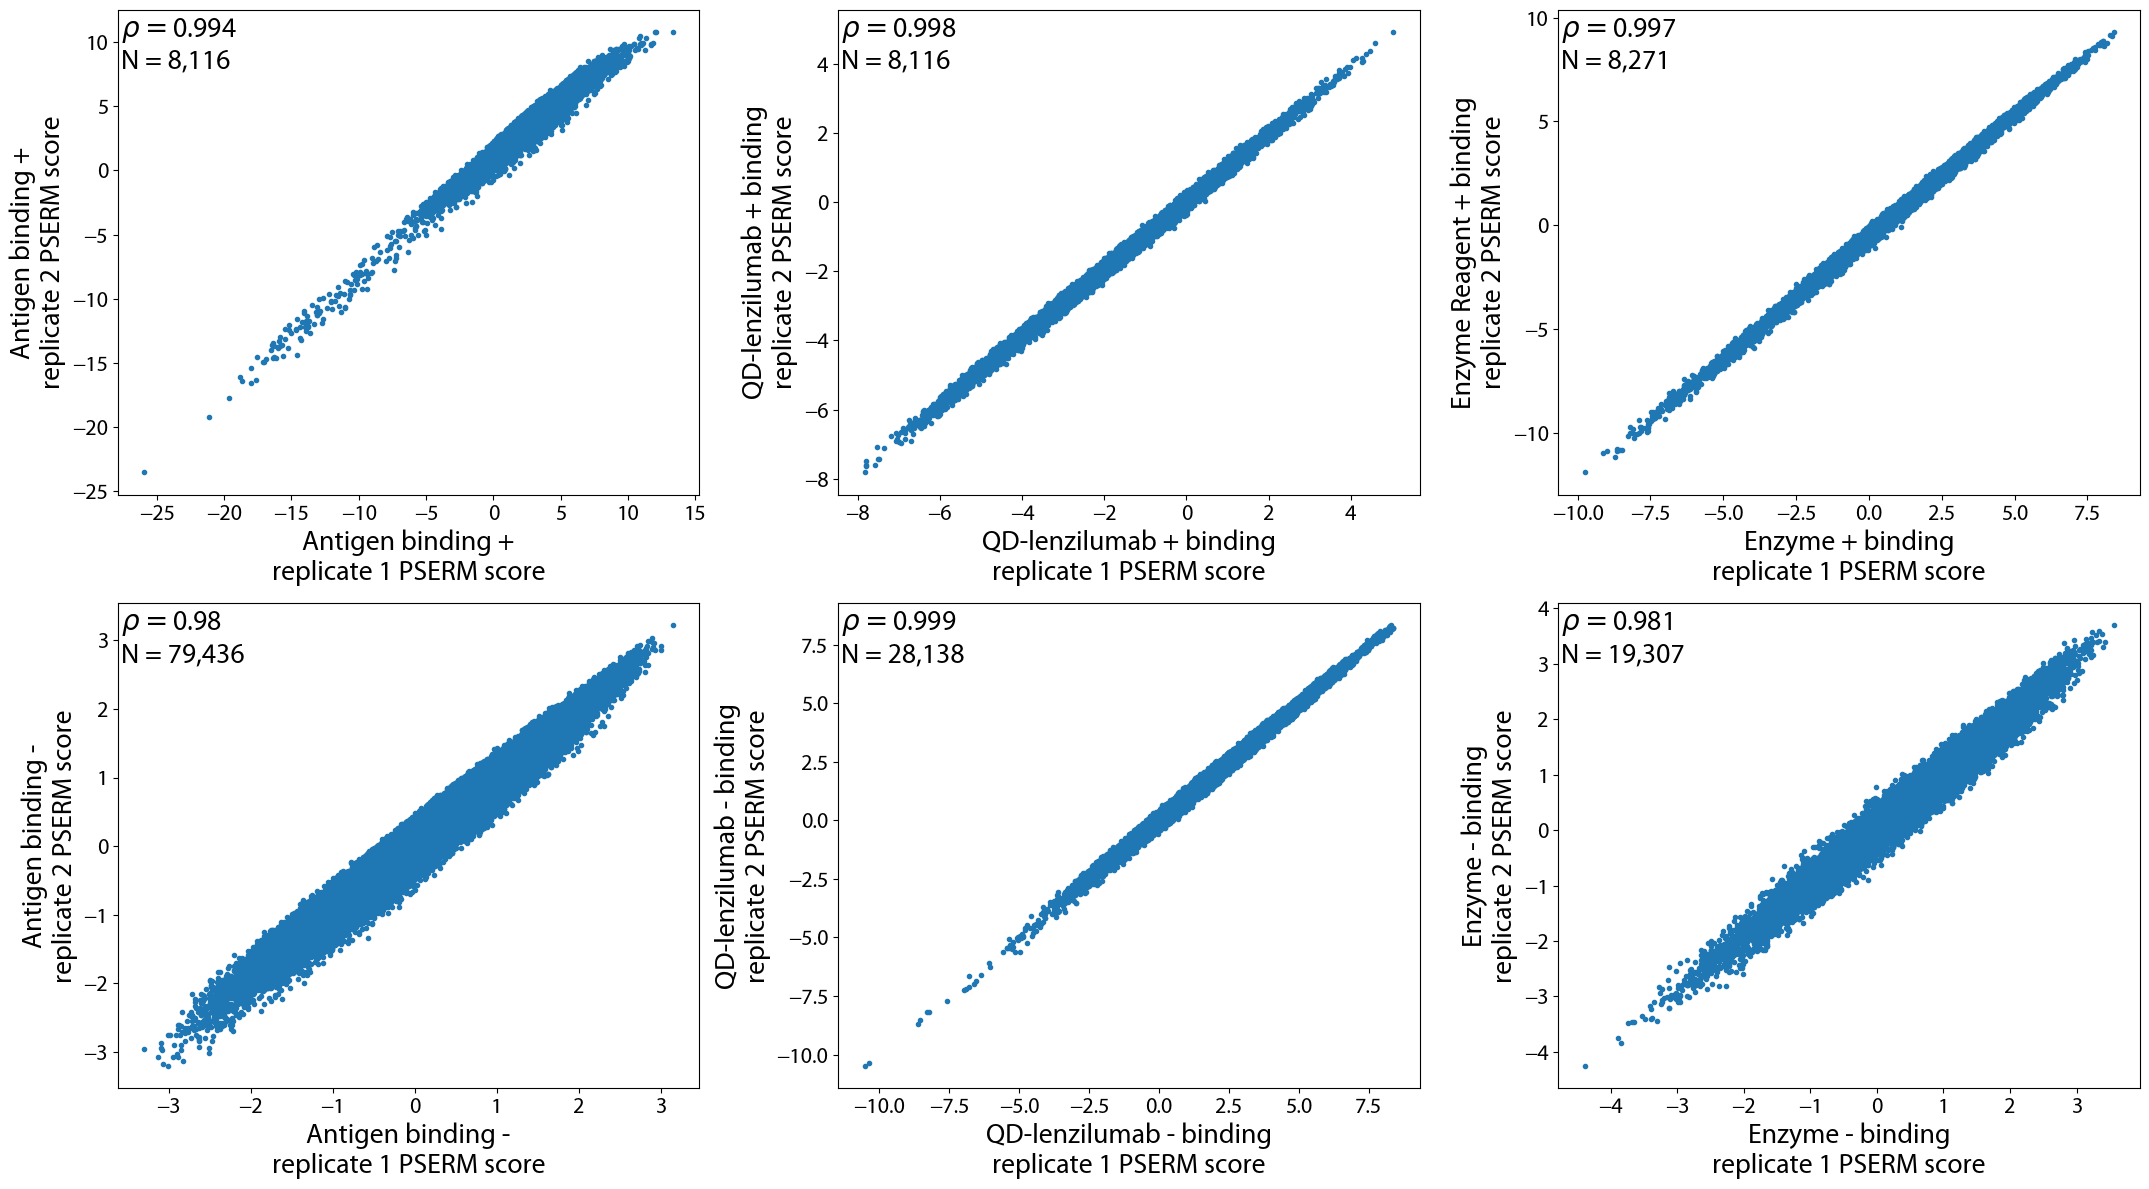

In [21]:
fig, axs = plt.subplots(2, 3, figsize = (7.2 * 3, 6 * 2))

#Antigen PSERMS
p2_r1_PSERM_er, p2_p1_PSERM_er = spearmanr(
    p2_data_r1.scores.loc[p2_er_clones_s1, 'AgP PSERM Score'], 
    p2_data_r2.scores.loc[p2_er_clones_s1, 'AgP PSERM Score'],
    nan_policy='omit')
axs[0, 0].plot(p2_data_r1.scores.loc[p2_er_clones_s1, 'AgP PSERM Score'], p2_data_r2.scores.loc[p2_er_clones_s1, 'AgP PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r1_PSERM:.3}' + f'\nN = {len(p2_er_clones_s1):,}')

axs[0, 0].set_xlabel('Antigen binding +\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 0].set_ylabel('Antigen binding +\n'+r'replicate 2 PSERM score', fontproperties = prop)

p2_r2_PSERM_er, p2_p2_PSERM_er = spearmanr(
    p2_data_r1.scores.loc[p2_er_clones_s2, 'AgN PSERM Score'], 
    p2_data_r2.scores.loc[p2_er_clones_s2, 'AgN PSERM Score'],
    nan_policy='omit')
axs[1, 0].plot(p2_data_r1.scores.loc[p2_er_clones_s2, 'AgN PSERM Score'], p2_data_r2.scores.loc[p2_er_clones_s2, 'AgN PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r2_PSERM:.3}' + f'\nN = {len(p2_er_clones_s2):,}')

axs[1, 0].set_xlabel('Antigen binding -\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 0].set_ylabel('Antigen binding -\n'+r'replicate 2 PSERM score', fontproperties = prop)

#Ova PSERMS
p2_r3_PSERM_er, p2_p3_PSERM_er = spearmanr(
    p2_data_r1.scores.loc[p2_er_clones_s3, 'QDP PSERM Score'], 
    p2_data_r2.scores.loc[p2_er_clones_s3, 'QDP PSERM Score'],
    nan_policy='omit')
axs[0, 1].plot(p2_data_r1.scores.loc[p2_er_clones_s1, 'QDP PSERM Score'], p2_data_r2.scores.loc[p2_er_clones_s1, 'QDP PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r3_PSERM:.3}' + f'\nN = {len(p2_er_clones_s1):,}')

axs[0, 1].set_xlabel('QD-lenzilumab + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 1].set_ylabel('QD-lenzilumab + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p2_r4_PSERM_er, p2_p4_PSERM_er = spearmanr(
    p2_data_r1.scores.loc[p2_er_clones_s4, 'QDN PSERM Score'], 
    p2_data_r2.scores.loc[p2_er_clones_s4, 'QDN PSERM Score'],
    nan_policy='omit')
axs[1, 1].plot(p2_data_r1.scores.loc[p2_er_clones_s4, 'QDN PSERM Score'], p2_data_r2.scores.loc[p2_er_clones_s4, 'QDN PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r4_PSERM:.3}' + f'\nN = {len(p2_er_clones_s4):,}')

axs[1, 1].set_xlabel('QD-lenzilumab - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 1].set_ylabel('QD-lenzilumab - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

#PSR PSERMS
p2_r5_PSERM_er, p2_p5_PSERM_er = spearmanr(
    p2_data_r1.scores.loc[p2_er_clones_s5, 'EP PSERM Score'], 
    p2_data_r2.scores.loc[p2_er_clones_s5, 'EP PSERM Score'],
    nan_policy='omit')
axs[0, 2].plot(p2_data_r1.scores.loc[p2_er_clones_s5, 'EP PSERM Score'], p2_data_r2.scores.loc[p2_er_clones_s5, 'EP PSERM Score'],
    '.', label = r'$\rho =$' + f'{p2_r5_PSERM:.3}' + f'\nN = {len(p2_er_clones_s5):,}')

axs[0, 2].set_xlabel('Enzyme + binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[0, 2].set_ylabel('Enzyme Reagent + binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

p2_r6_PSERM_er, p2_p6_PSERM_er = spearmanr(
    p2_data_r1.scores.loc[p2_er_clones_s6, 'EN PSERM Score'], 
    p2_data_r2.scores.loc[p2_er_clones_s6, 'EN PSERM Score'],
    nan_policy='omit')
axs[1, 2].plot(p2_data_r1.scores.loc[p2_er_clones_s6, 'EN PSERM Score'], p2_data_r2.scores.loc[p2_er_clones_s6, 'EN PSERM Score'],
    '.', label =  r'$\rho =$' + f'{p2_r6_PSERM:.3}' + f'\nN = {len(p2_er_clones_s6):,}')

axs[1, 2].set_xlabel('Enzyme - binding\n'+r'replicate 1 PSERM score', fontproperties = prop)
axs[1, 2].set_ylabel('Enzyme - binding\n'+r'replicate 2 PSERM score', fontproperties = prop)

#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)
    
    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)
        
plt.tight_layout()

plt.show()

# Project 3

## Setups and data processing

In [22]:
#Project 3 was initially planned to utilize a different type of analysis and the data is organized into a different class
#however this is essentially a superficial change.

#Project 3 WT
p3_wt = 'SASFYFDTYI'

#Allowed mutations with NNK is everything
p3_muts_no_wt = {
0: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y'], #S
1: ['C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #A
2: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y'], #S
3: ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #F
4: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W'], #Y
5: ['A', 'C', 'D', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #F
6: ['A', 'C', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #D
7: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'V', 'W', 'Y'], #T
8: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W'], #Y
9: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], #I 
}

#DMD data objects
p3_r1 = NGS_DMD(
    sequence_type = 'mutations', samples = ['R2', 'R3', 'R5', 'R6', 'R7'],
    path = '../Input_Datasets/Project_3/Rep_1/', wild_type = p3_wt, mutations_dict = p3_muts_no_wt
)

p3_r2 = NGS_DMD(
    sequence_type = 'mutations', samples = ['R2', 'R3', 'R5', 'R6', 'R7'],
    path = '../Input_Datasets/Project_3/Rep_2/', wild_type = p3_wt, mutations_dict = p3_muts_no_wt
)

['Mutation_1001.csv', 'Mutation_1003.csv', 'Mutation_1005.csv', 'Mutation_1007.csv', 'Mutation_1009.csv']
['Mutation_1001.csv', 'Mutation_1003.csv', 'Mutation_1005.csv', 'Mutation_1007.csv', 'Mutation_1009.csv']


In [23]:
p3_clone_set_trimmed_r1 = generate_clone_set(p3_r1, ['R2', 'R3', 'R5', 'R6', 'R7'])
p3_clone_set_trimmed_r2 = generate_clone_set(p3_r2, ['R2', 'R3', 'R5', 'R6', 'R7'])

p3_data_r1 = ngs_analysis([p3_r1], ['R2', 'R3', 'R5', 'R6', 'R7'], clone_set = p3_clone_set_trimmed_r1)
p3_data_r2 = ngs_analysis([p3_r2], ['R2', 'R3', 'R5', 'R6', 'R7'], clone_set = p3_clone_set_trimmed_r2)

p3_data_r1.generate_D()
p3_data_r2.generate_D()

100%|██████████| 23417/23417 [00:00<00:00, 367289.61it/s]


In [24]:
for sample in tqdm.tqdm(p3_data_r1.samples):
    p3_data_r1.generate_PSSM(sample)
    p3_data_r2.generate_PSSM(sample)

for sample in tqdm.tqdm(p3_data_r1.samples):
    if sample != 'R2':
        p3_data_r1.generate_PSERM(In_sample = 'R2', Out_sample = sample)
        p3_data_r2.generate_PSERM(In_sample = 'R2', Out_sample = sample)

  0%|          | 0/5 [00:00<?, ?it/s]

Generating MSA.


100%|██████████| 10/10 [00:00<00:00, 21.05it/s]


Generating MSA.


100%|██████████| 5/5 [00:00<00:00, 2903.44it/s]


In [25]:
p3_data_r1.score_all_clones_mp(method = 'PSERM')
p3_data_r2.score_all_clones_mp(method = 'PSERM')

Done in 0.06 minutes
Done in 0.06 minutes


## Plots

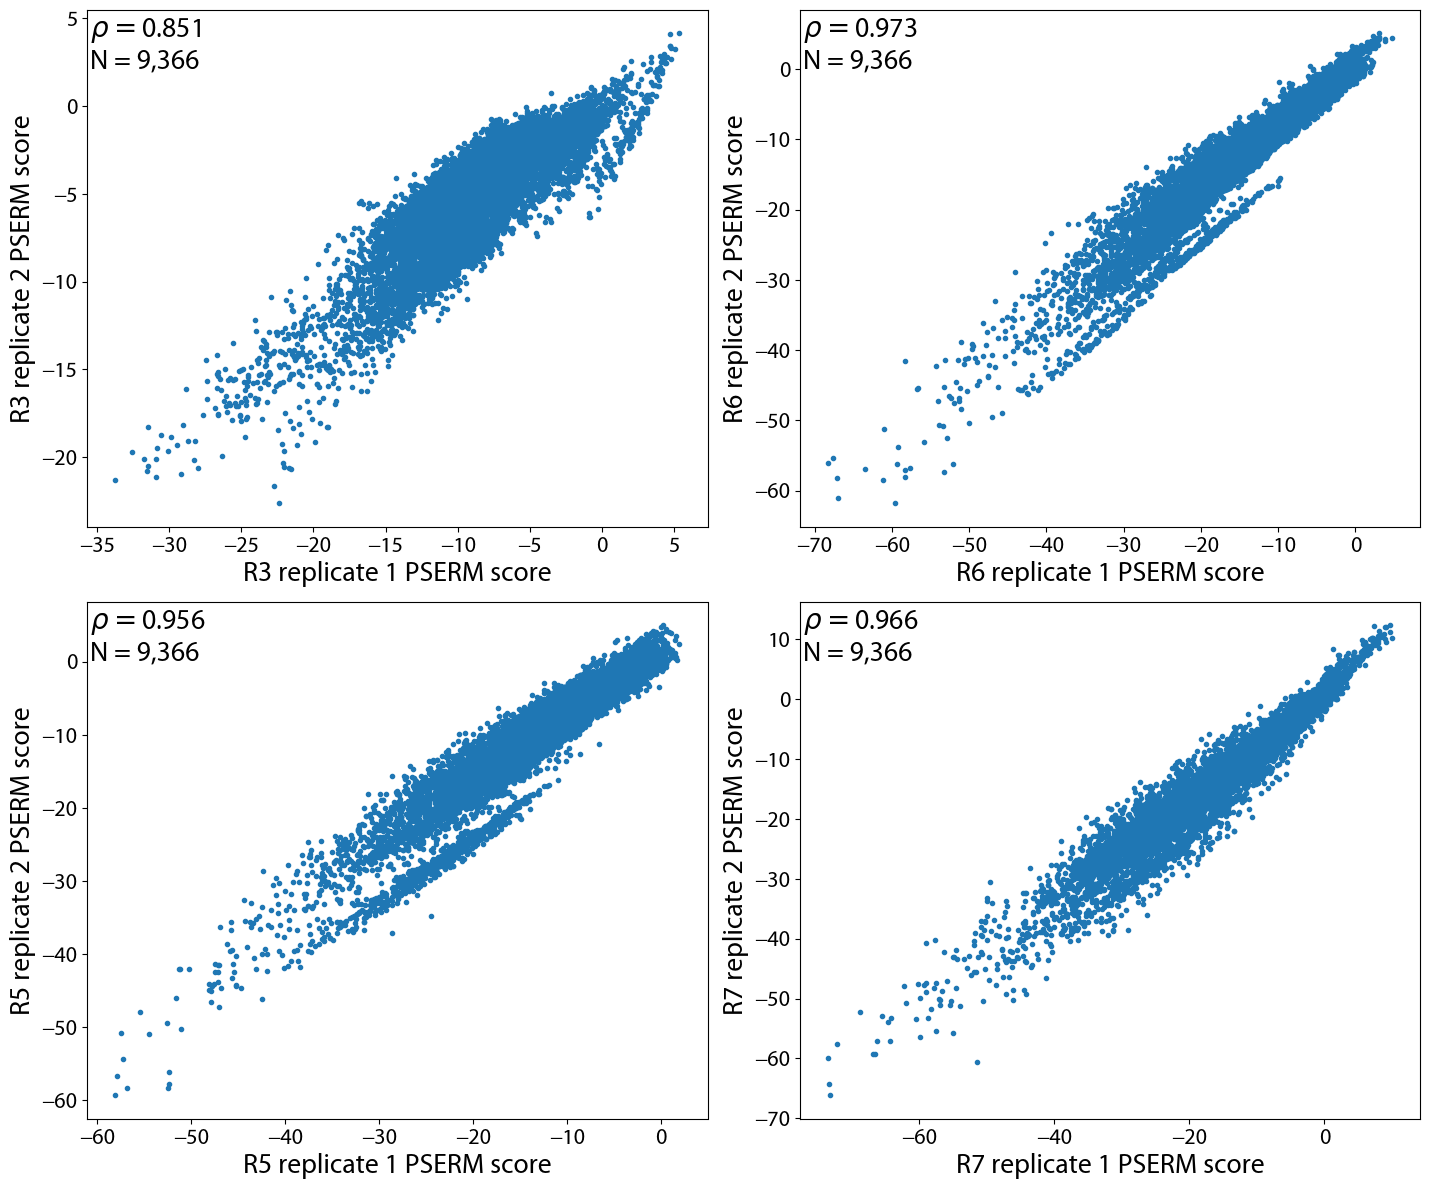

In [26]:
common_seqs_p3 = list(set(p3_data_r1.scores.index).intersection(set(p3_data_r2.scores.index)))

fig, axs = plt.subplots(2, 2, figsize = (7.2 * 2, 6 * 2))

#Antigen PSERMS
p3_r1_PSERM, p3_p1_PSERM = spearmanr(
    p3_data_r1.scores.loc[common_seqs_p3, 'R3 PSERM Score'], 
    p3_data_r2.scores.loc[common_seqs_p3, 'R3 PSERM Score'],
    nan_policy='omit')
axs[0, 0].plot(p3_data_r1.scores.loc[common_seqs_p3, 'R3 PSERM Score'], p3_data_r2.scores.loc[common_seqs_p3, 'R3 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r1_PSERM:.3}' + f'\nN = {len(common_seqs_p3):,}')

axs[0, 0].set_xlabel(r'R3 replicate 1 PSERM score', fontproperties = prop)
axs[0, 0].set_ylabel(r'R3 replicate 2 PSERM score', fontproperties = prop)

p3_r2_PSERM, p3_p2_PSERM = spearmanr(
    p3_data_r1.scores.loc[common_seqs_p3, 'R5 PSERM Score'], 
    p3_data_r2.scores.loc[common_seqs_p3, 'R5 PSERM Score'],
    nan_policy='omit')
axs[1, 0].plot(p3_data_r1.scores.loc[common_seqs_p3, 'R5 PSERM Score'], p3_data_r2.scores.loc[common_seqs_p3, 'R5 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r2_PSERM:.3}' + f'\nN = {len(common_seqs_p3):,}')

axs[1, 0].set_xlabel(r'R5 replicate 1 PSERM score', fontproperties = prop)
axs[1, 0].set_ylabel(r'R5 replicate 2 PSERM score', fontproperties = prop)

#Ova PSERMS
p3_r3_PSERM, p3_p3_PSERM = spearmanr(
    p3_data_r1.scores.loc[common_seqs_p3, 'R6 PSERM Score'], 
    p3_data_r2.scores.loc[common_seqs_p3, 'R6 PSERM Score'],
    nan_policy='omit')
axs[0, 1].plot(p3_data_r1.scores.loc[common_seqs_p3, 'R6 PSERM Score'], p3_data_r2.scores.loc[common_seqs_p3, 'R6 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r3_PSERM:.3}' + f'\nN = {len(common_seqs_p3):,}')

axs[0, 1].set_xlabel(r'R6 replicate 1 PSERM score', fontproperties = prop)
axs[0, 1].set_ylabel(r'R6 replicate 2 PSERM score', fontproperties = prop)

p3_r4_PSERM, p3_p4_PSERM = spearmanr(
    p3_data_r1.scores.loc[common_seqs_p3, 'R7 PSERM Score'], 
    p3_data_r2.scores.loc[common_seqs_p3, 'R7 PSERM Score'],
    nan_policy='omit')
axs[1, 1].plot(p3_data_r1.scores.loc[common_seqs_p3, 'R7 PSERM Score'], p3_data_r2.scores.loc[common_seqs_p3, 'R7 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r4_PSERM:.3}' + f'\nN = {len(common_seqs_p3):,}')

axs[1, 1].set_xlabel(r'R7 replicate 1 PSERM score', fontproperties = prop)
axs[1, 1].set_ylabel(r'R7 replicate 2 PSERM score', fontproperties = prop)

#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()

plt.show()

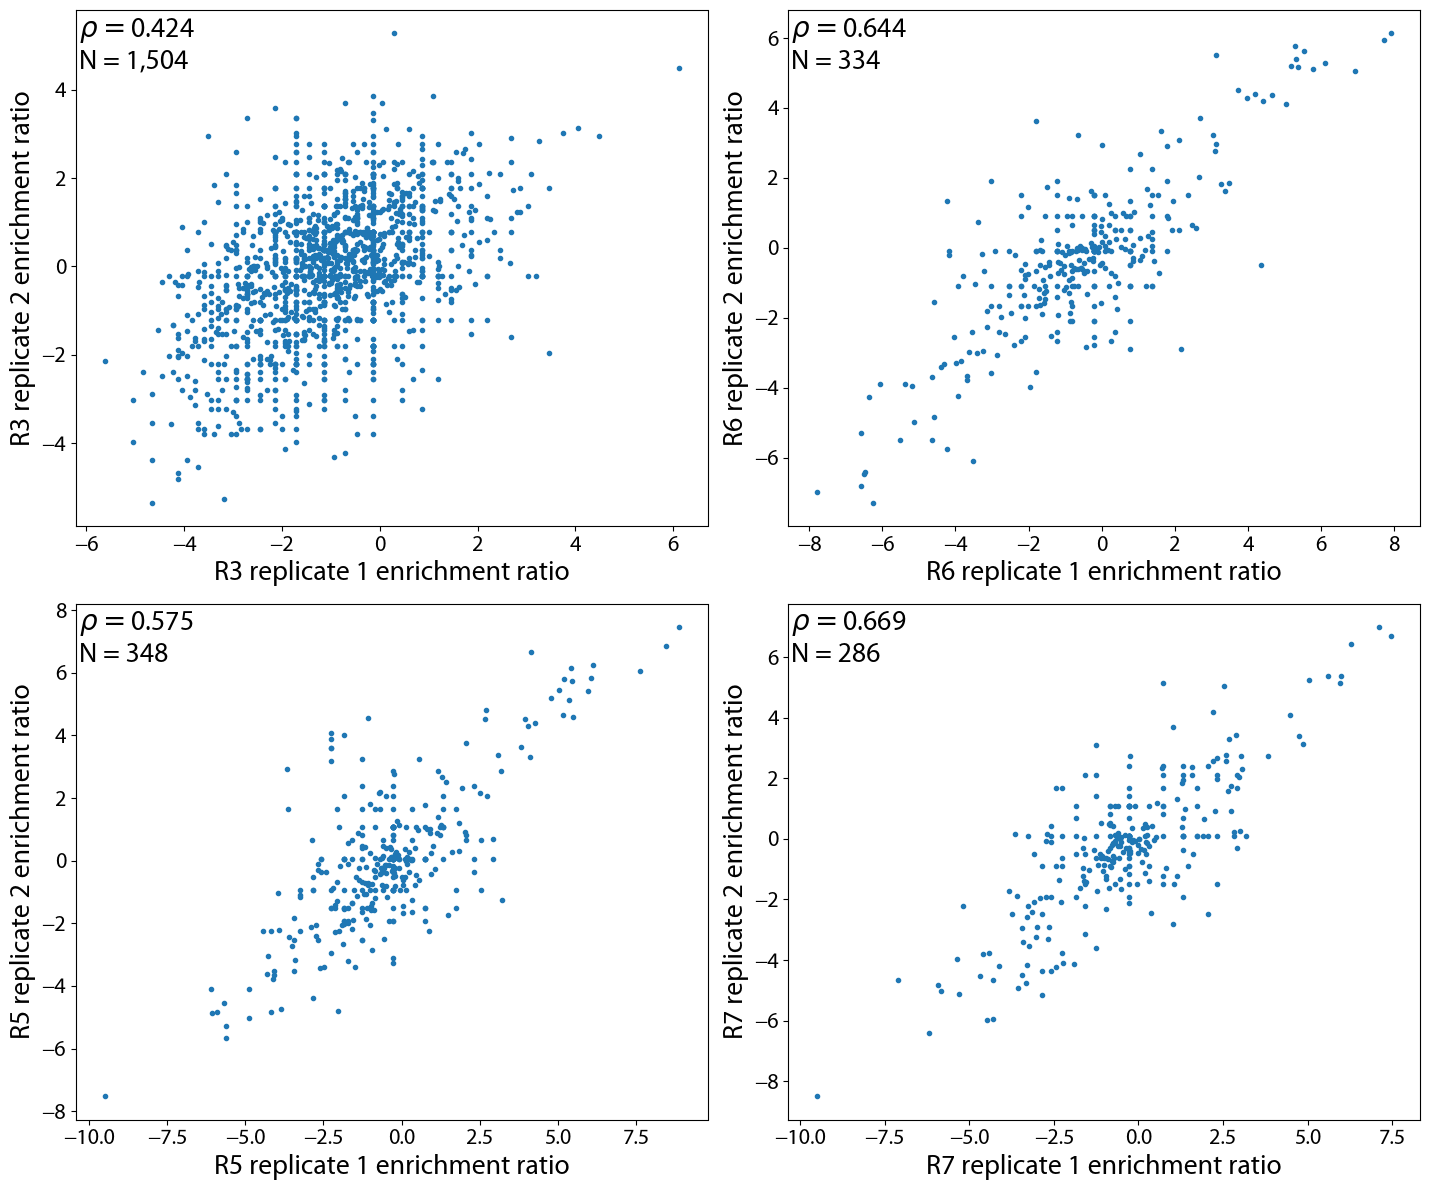

In [27]:
fig, axs = plt.subplots(2, 2, figsize = (7.2 * 2, 6 * 2))

##############Ag plots##############
p3_r1_clones = set(p3_data_r1.D[(p3_data_r1.D['R2'] > 0) & (p3_data_r1.D['R3'] > 0)].index)
p3_r2_clones = set(p3_data_r2.D[(p3_data_r2.D['R2'] > 0) & (p3_data_r2.D['R3'] > 0)].index)

p3_er_clones_s1 = list(p3_r1_clones.intersection(p3_r2_clones))

p3_r1_er, p3_p1_er = spearmanr(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s1, 'R3'] / p3_data_r1.D.loc[p3_er_clones_s1, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s1, 'R3'] / p3_data_r2.D.loc[p3_er_clones_s1, 'R2']))
axs[0, 0].plot(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s1, 'R3'] / p3_data_r1.D.loc[p3_er_clones_s1, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s1, 'R3'] / p3_data_r2.D.loc[p3_er_clones_s1, 'R2']), 
    '.', label = r'$\rho =$' + f'{p3_r1_er:.3}' + f'\nN = {len(p3_er_clones_s1):,}')

axs[0, 0].set_xlabel(r'R3 replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 0].set_ylabel(r'R3 replicate 2 enrichment ratio', fontproperties = prop)

p3_r1_clones = set(p3_data_r1.D[(p3_data_r1.D['R2'] > 0) & (p3_data_r1.D['R5'] > 0)].index)
p3_r2_clones = set(p3_data_r2.D[(p3_data_r2.D['R2'] > 0) & (p3_data_r2.D['R5'] > 0)].index)

p3_er_clones_s2 = list(p3_r1_clones.intersection(p3_r2_clones))

p3_r2_er, p3_p2_er = spearmanr(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s2, 'R5'] / p3_data_r1.D.loc[p3_er_clones_s2, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s2, 'R5'] / p3_data_r2.D.loc[p3_er_clones_s2, 'R2']))
axs[1, 0].plot(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s2, 'R5'] / p3_data_r1.D.loc[p3_er_clones_s2, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s2, 'R5'] / p3_data_r2.D.loc[p3_er_clones_s2, 'R2']), 
    '.', label = r'$\rho =$' + f'{p3_r2_er:.3}' + f'\nN = {len(p3_er_clones_s2):,}')

axs[1, 0].set_xlabel(r'R5 replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 0].set_ylabel(r'R5 replicate 2 enrichment ratio', fontproperties = prop)

p3_r1_clones = set(p3_data_r1.D[(p3_data_r1.D['R2'] > 0) & (p3_data_r1.D['R6'] > 0)].index)
p3_r2_clones = set(p3_data_r2.D[(p3_data_r2.D['R2'] > 0) & (p3_data_r2.D['R6'] > 0)].index)

p3_er_clones_s3 = list(p3_r1_clones.intersection(p3_r2_clones))

p3_r3_er, p3_p3_er = spearmanr(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s3, 'R6'] / p3_data_r1.D.loc[p3_er_clones_s3, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s3, 'R6'] / p3_data_r2.D.loc[p3_er_clones_s3, 'R2']))
axs[0, 1].plot(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s3, 'R6'] / p3_data_r1.D.loc[p3_er_clones_s3, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s3, 'R6'] / p3_data_r2.D.loc[p3_er_clones_s3, 'R2']), 
    '.', label = r'$\rho =$' + f'{p3_r3_er:.3}' + f'\nN = {len(p3_er_clones_s3):,}')

axs[0, 1].set_xlabel(r'R6 replicate 1 enrichment ratio', fontproperties = prop)
axs[0, 1].set_ylabel(r'R6 replicate 2 enrichment ratio', fontproperties = prop)

p3_r1_clones = set(p3_data_r1.D[(p3_data_r1.D['R2'] > 0) & (p3_data_r1.D['R7'] > 0)].index)
p3_r2_clones = set(p3_data_r2.D[(p3_data_r2.D['R2'] > 0) & (p3_data_r2.D['R7'] > 0)].index)

p3_er_clones_s4 = list(p3_r1_clones.intersection(p3_r2_clones))

p3_r4_er, p3_p4_er = spearmanr(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s4, 'R7'] / p3_data_r1.D.loc[p3_er_clones_s4, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s4, 'R7'] / p3_data_r2.D.loc[p3_er_clones_s4, 'R2']))
axs[1, 1].plot(
    np.log2(p3_data_r1.D.loc[p3_er_clones_s4, 'R7'] / p3_data_r1.D.loc[p3_er_clones_s4, 'R2']), 
    np.log2(p3_data_r2.D.loc[p3_er_clones_s4, 'R7'] / p3_data_r2.D.loc[p3_er_clones_s4, 'R2']), 
    '.', label = r'$\rho =$' + f'{p3_r4_er:.3}' + f'\nN = {len(p3_er_clones_s4):,}')

axs[1, 1].set_xlabel(r'R7 replicate 1 enrichment ratio', fontproperties = prop)
axs[1, 1].set_ylabel(r'R7 replicate 2 enrichment ratio', fontproperties = prop)

#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()

plt.show()


## PSERM on ER Clone Set

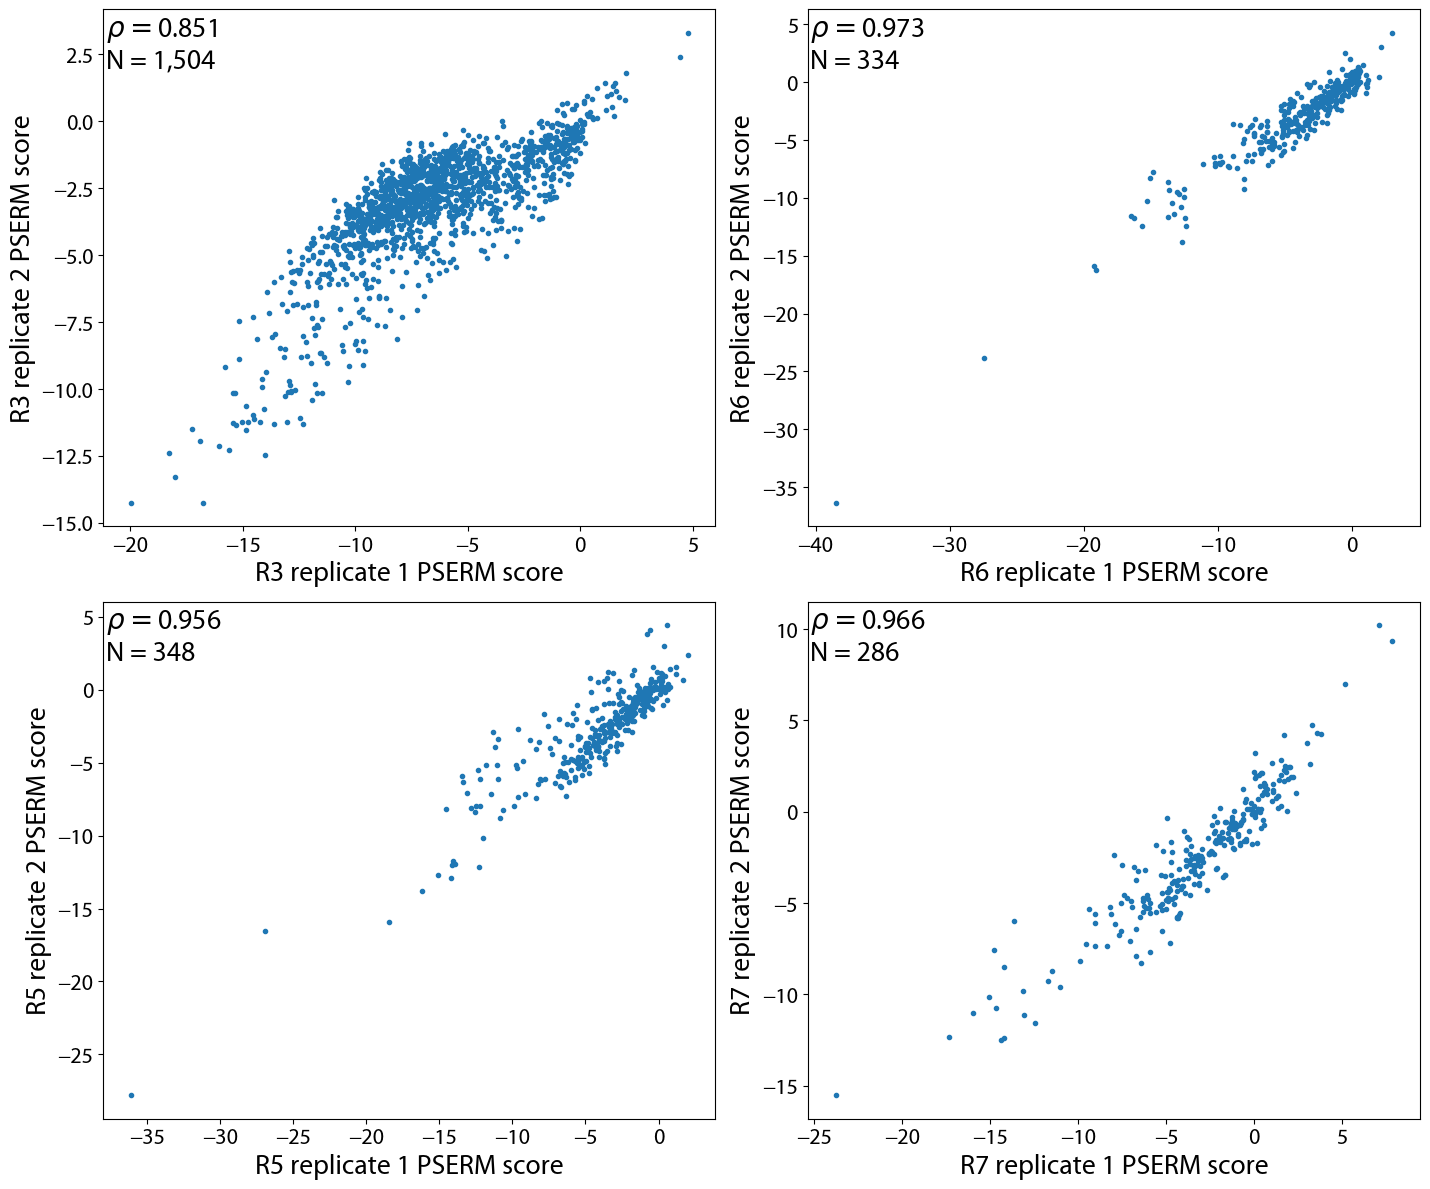

In [28]:
fig, axs = plt.subplots(2, 2, figsize = (7.2 * 2, 6 * 2))

#Antigen PSERMS
p3_r1_PSERM_er, p3_p1_PSERM_er = spearmanr(
    p3_data_r1.scores.loc[p3_er_clones_s1, 'R3 PSERM Score'], 
    p3_data_r2.scores.loc[p3_er_clones_s1, 'R3 PSERM Score'],
    nan_policy='omit')
axs[0, 0].plot(p3_data_r1.scores.loc[p3_er_clones_s1, 'R3 PSERM Score'], p3_data_r2.scores.loc[p3_er_clones_s1, 'R3 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r1_PSERM:.3}' + f'\nN = {len(p3_er_clones_s1):,}')

axs[0, 0].set_xlabel(r'R3 replicate 1 PSERM score', fontproperties = prop)
axs[0, 0].set_ylabel(r'R3 replicate 2 PSERM score', fontproperties = prop)

p3_r2_PSERM_er, p3_p2_PSERM_er = spearmanr(
    p3_data_r1.scores.loc[p3_er_clones_s2, 'R5 PSERM Score'], 
    p3_data_r2.scores.loc[p3_er_clones_s2, 'R5 PSERM Score'],
    nan_policy='omit')
axs[1, 0].plot(p3_data_r1.scores.loc[p3_er_clones_s2, 'R5 PSERM Score'], p3_data_r2.scores.loc[p3_er_clones_s2, 'R5 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r2_PSERM:.3}' + f'\nN = {len(p3_er_clones_s2):,}')

axs[1, 0].set_xlabel(r'R5 replicate 1 PSERM score', fontproperties = prop)
axs[1, 0].set_ylabel(r'R5 replicate 2 PSERM score', fontproperties = prop)

#Ova PSERMS
p3_r3_PSERM_er, p3_p3_PSERM_er= spearmanr(
    p3_data_r1.scores.loc[p3_er_clones_s3, 'R6 PSERM Score'], 
    p3_data_r2.scores.loc[p3_er_clones_s3, 'R6 PSERM Score'],
    nan_policy='omit')
axs[0, 1].plot(p3_data_r1.scores.loc[p3_er_clones_s3, 'R6 PSERM Score'], p3_data_r2.scores.loc[p3_er_clones_s3, 'R6 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r3_PSERM:.3}' + f'\nN = {len(p3_er_clones_s3):,}')

axs[0, 1].set_xlabel(r'R6 replicate 1 PSERM score', fontproperties = prop)
axs[0, 1].set_ylabel(r'R6 replicate 2 PSERM score', fontproperties = prop)

p3_r4_PSERM_er, p3_p4_PSERM_er = spearmanr(
    p3_data_r1.scores.loc[p3_er_clones_s4, 'R7 PSERM Score'], 
    p3_data_r2.scores.loc[p3_er_clones_s4, 'R7 PSERM Score'],
    nan_policy='omit')
axs[1, 1].plot(p3_data_r1.scores.loc[p3_er_clones_s4, 'R7 PSERM Score'], p3_data_r2.scores.loc[p3_er_clones_s4, 'R7 PSERM Score'],
    '.', label = r'$\rho =$' + f'{p3_r4_PSERM:.3}' + f'\nN = {len(p3_er_clones_s4):,}')

axs[1, 1].set_xlabel(r'R7 replicate 1 PSERM score', fontproperties = prop)
axs[1, 1].set_ylabel(r'R7 replicate 2 PSERM score', fontproperties = prop)

#Format ticklabels 
for ax in axs.ravel():
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(tickprop)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(tickprop)

    legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
    for marker in legend.legendHandles:
        marker.set_visible(False)

plt.tight_layout()

plt.show()

# Summary

In [30]:
# Create dataframe of results...

results = {}
results['Dataset 1'] = [p1_r1_PSERM, p1_r1_er, p1_r1_PSERM_er, len(common_seqs_p1), len(p1_er_clones_s1)]
results['Dataset 2'] = [p1_r2_PSERM, p1_r2_er, p1_r2_PSERM_er, len(common_seqs_p1), len(p1_er_clones_s2)]
results['Dataset 3'] = [p1_r3_PSERM, p1_r3_er, p1_r3_PSERM_er, len(common_seqs_p1), len(p1_er_clones_s3)]
results['Dataset 4'] = [p1_r4_PSERM, p1_r4_er, p1_r4_PSERM_er, len(common_seqs_p1), len(p1_er_clones_s4)]
results['Dataset 5'] = [p1_r5_PSERM, p1_r5_er, p1_r5_PSERM_er, len(common_seqs_p1), len(p1_er_clones_s5)]
results['Dataset 6'] = [p1_r6_PSERM, p1_r6_er, p1_r6_PSERM_er, len(common_seqs_p1), len(p1_er_clones_s6)]

results['Dataset 7'] = [p2_r1_PSERM, p2_r1_er, p2_r1_PSERM_er, len(common_seqs_p2), len(p2_er_clones_s1)]
results['Dataset 8'] = [p2_r2_PSERM, p2_r2_er, p2_r2_PSERM_er, len(common_seqs_p2), len(p2_er_clones_s2)]
results['Dataset 9'] = [p2_r3_PSERM, p2_r3_er, p2_r3_PSERM_er, len(common_seqs_p2), len(p2_er_clones_s3)]
results['Dataset 10'] = [p2_r4_PSERM, p2_r4_er, p2_r4_PSERM_er, len(common_seqs_p2), len(p2_er_clones_s4)]
results['Dataset 11'] = [p2_r5_PSERM, p2_r5_er, p2_r5_PSERM_er, len(common_seqs_p2), len(p2_er_clones_s5)]
results['Dataset 12'] = [p2_r6_PSERM, p2_r6_er, p2_r6_PSERM_er, len(common_seqs_p2), len(p2_er_clones_s6)]

results['Dataset 13'] = [p3_r1_PSERM, p3_r1_er, p3_r1_PSERM_er, len(common_seqs_p3), len(p3_er_clones_s1)]
results['Dataset 14'] = [p3_r2_PSERM, p3_r2_er, p3_r2_PSERM_er, len(common_seqs_p3), len(p3_er_clones_s2)]
results['Dataset 15'] = [p3_r3_PSERM, p3_r3_er, p3_r3_PSERM_er, len(common_seqs_p3), len(p3_er_clones_s3)]
results['Dataset 16'] = [p3_r4_PSERM, p3_r4_er, p3_r4_PSERM_er, len(common_seqs_p3), len(p3_er_clones_s4)]

results = pd.DataFrame.from_dict(results, orient = 'index', columns = ['PSERM spearman rho', 'ER spearman rho', 'PSERM spearman rho ER set', 'PSERM N', 'ER N'])
#results.to_excel('Final All Datasets Reproducibility Scores.xlsx')

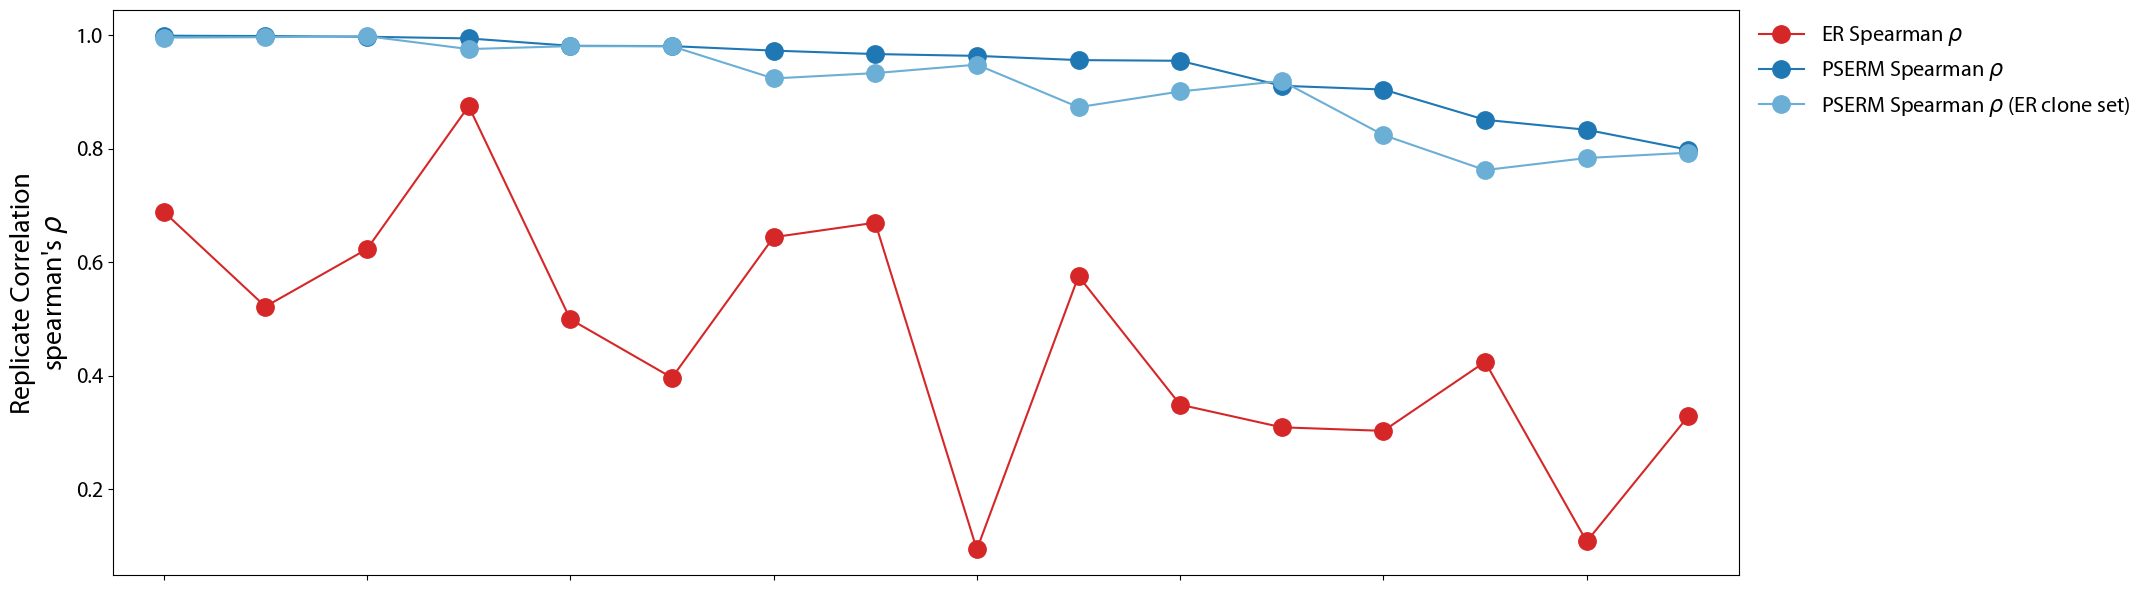

In [38]:
fname = None
sort_by = 'PSERM spearman rho'
show = True

#Sort dataframe by decreasing PSERM spearman rho (sort_by variable)
results_sorted = results.sort_values(sort_by, ascending = False)

#Create dummy x variable list
x = list(range(len(results_sorted)))

#create figure and subplots. Top is reproducibility bottom is number of scoreable sequences.
fig, ax = plt.subplots(1, 1, figsize = (7.2 * 3, 6))

#plot reproducibility
ax.plot(x, results_sorted.loc[:, 'ER spearman rho'], 
            '.-', color = plt.get_cmap('tab10')(3), 
            label = r'ER Spearman $\rho$', markersize = 25)

ax.plot(x, results_sorted.loc[:, 'PSERM spearman rho'], 
            '.-', color = plt.get_cmap('tab10')(0), 
            label = r'PSERM Spearman $\rho$', markersize = 25)

ax.plot(x, results_sorted.loc[:, 'PSERM spearman rho ER set'], 
            '.-', color = plt.get_cmap('tab20c')(1), 
            label = r'PSERM Spearman $\rho$ (ER clone set)', markersize = 25)

#remove x-axis ticks and lables and set y-axis label

ax.set_xticklabels([])
ax.set_ylabel('Replicate Correlation\n' + r"spearman's $\rho$", fontproperties = prop)

for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_fontproperties(prop)        
for tick in ax.get_yticklabels():
    tick.set_fontproperties(tickprop)    

ax.legend(bbox_to_anchor = (1.0, 1.01), frameon = False, prop = tickprop)
ax.set_xlim(-0.5, max(x) + 0.5)

#save figure
plt.tight_layout()
if fname is not None:
    if not fname.endswith('.pdf'):
        fname = f'{fname}.pdf'
    else:
        plt.savefig(fname, transparent = True)
if show:
    plt.show()


# Create Figure 2

In [2]:

#Figure 2A
def create_specific_reproducibility_figure(ngs_analysis_r1, ngs_analysis_r2, output_sample, input_sample = 'Input', fname = None, show = True, rasterized = True):
    ''' Creates 4 panel figure of input/output frequencies for each replicate as well as ER and PSERM '''
    
    #Checks to make sure the PSERM Scores are available
    try: ngs_analysis_r1.scores
    except: 
        print('PSERM Scores need to be calculated prior to running this function for at least replicate 1')
        return
    try: ngs_analysis_r2.scores
    except: 
        print('PSERM Scores need to be calculated prior to running this function for replitcate 2')
        return

    fig, axs = plt.subplots(1, 4, figsize = (7.2 * 4, 6 * 1))

    # get common clones to input and/or output sample for both replicates.
    in_cc = list(set(ngs_analysis_r1.D[ngs_analysis_r1.D[input_sample] > 0].index).intersection(set(ngs_analysis_r2.D[ngs_analysis_r2.D[input_sample] > 0].index)))
    out_cc = list(set(ngs_analysis_r1.D[ngs_analysis_r1.D[output_sample] > 0].index).intersection(set(ngs_analysis_r2.D[ngs_analysis_r2.D[output_sample] > 0].index)))
    er_cc = list(set(in_cc).intersection(set(out_cc)))
    cc = list(set(ngs_analysis_r1.D.index).intersection(set(ngs_analysis_r2.D.index)))

    #compute spearman r for input frequency between the two replicates and then plot
    in_r, in_p = spearmanr(
        ngs_analysis_r1.D.loc[in_cc, input_sample],
        ngs_analysis_r2.D.loc[in_cc, input_sample]
    )
    axs[0].plot(
        ngs_analysis_r1.D.loc[in_cc, input_sample],
        ngs_analysis_r2.D.loc[in_cc, input_sample], 
        '.', label = r'$\rho =$' + f'{in_r:.3}' + f'\nN = {len(in_cc):,}',
        rasterized = rasterized 
    )
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].set_xlabel(f'Replicate 1 {input_sample.lower()} frequency', fontproperties = prop)
    axs[0].set_ylabel(f'Replicate 2 {input_sample.lower()} frequency', fontproperties = prop)
    
    #compute spearman r for output frequency between the two replicates and then plot
    out_r, out_p = spearmanr(
        ngs_analysis_r1.D.loc[out_cc, output_sample],
        ngs_analysis_r2.D.loc[out_cc, output_sample]
    )
    axs[1].plot(
        ngs_analysis_r1.D.loc[out_cc, output_sample],
        ngs_analysis_r2.D.loc[out_cc, output_sample], 
        '.', label = r'$\rho =$' + f'{out_r:.3}' + f'\nN = {len(out_cc):,}',
        rasterized = rasterized 
    )
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Replicate 1 output frequency', fontproperties = prop)
    axs[1].set_ylabel('Replicate 2 output frequency', fontproperties = prop)

    #compute spearmanr for ER between the two replicates and then plot
    er_r, er_p = spearmanr(
        np.log2(ngs_analysis_r1.D.loc[er_cc, output_sample] / ngs_analysis_r1.D.loc[er_cc, input_sample]),
        np.log2(ngs_analysis_r2.D.loc[er_cc, output_sample] / ngs_analysis_r2.D.loc[er_cc, input_sample]),
    )
    axs[2].plot(
        np.log2(ngs_analysis_r1.D.loc[er_cc, output_sample] / ngs_analysis_r1.D.loc[er_cc, input_sample]),
        np.log2(ngs_analysis_r2.D.loc[er_cc, output_sample] / ngs_analysis_r2.D.loc[er_cc, input_sample]),
        '.', label = r'$\rho =$' + f'{er_r:.3}' + f'\nN = {len(er_cc):,}',
        rasterized = rasterized 
    )
    axs[2].set_xlabel('Replicate 1 enrichment ratio', fontproperties = prop)
    axs[2].set_ylabel('Replicate 2 enrichment ratio', fontproperties = prop)
    
    #compute spearmanr for PSERM score between the two replicates and then plot
    PSERM_r, PSERM_p = spearmanr(
        ngs_analysis_r1.scores.loc[cc, f'{output_sample} PSERM Score'],
        ngs_analysis_r2.scores.loc[cc, f'{output_sample} PSERM Score']
    )
    axs[3].plot(
        ngs_analysis_r1.scores.loc[cc, f'{output_sample} PSERM Score'],
        ngs_analysis_r2.scores.loc[cc, f'{output_sample} PSERM Score'],
        '.', label = r'$\rho =$' + f'{PSERM_r:.3}' + f'\nN = {len(cc):,}',
        rasterized = rasterized 
    )
    axs[3].set_xlabel(r'Replicate 1 PSERM score', fontproperties = prop)
    axs[3].set_ylabel(r'Replicate 2 PSERM score', fontproperties = prop)

    #Format ticklabels 
    for ax in axs.ravel():
        for tick in ax.get_xticklabels():
            tick.set_fontproperties(tickprop)
        for tick in ax.get_yticklabels():
            tick.set_fontproperties(tickprop)
            
        legend = ax.legend(handlelength = 0, handletextpad = -0.1, borderaxespad = 0.2, borderpad = 0, loc = 2, prop = prop, frameon = False)
        for marker in legend.legendHandles:
            marker.set_visible(False)
    plt.tight_layout()
    if fname is not None:
        if not fname.endswith('.pdf'):
            fname = f'{fname}.pdf'
        else:
            plt.savefig(fname, transparent = True)
    if show:
        plt.show()

# Figure 2B
def create_reproducibility_summary_figure(correlations_xlsx, sheet_name, fname = None, sort_by = 'PSERM spearman rho', show = True):
    #Read in dataframe containing reproducibilities and number of scoreable sequences.
    cor_bar = pd.read_excel(correlations_xlsx, sheet_name = sheet_name, index_col = 0)

    #Sort dataframe by decreasing PSERM spearman rho (sort_by variable)
    cor_bar_sorted = cor_bar.sort_values(sort_by, ascending = False)

    #Create dummy x variable list
    x = list(range(len(cor_bar_sorted)))

    #create figure and subplots. Top is reproducibility bottom is number of scoreable sequences.
    fig, axs = plt.subplots(figsize = (7.2 * 3, 6))

    #plot reproducibility
    axs.plot(x, cor_bar_sorted.loc[:, 'ER spearman rho'], 
                '.-', color = plt.get_cmap('tab10')(3), 
                label = r'ER Spearman $\rho$', markersize = 25)

    axs.plot(x, cor_bar_sorted.loc[:, 'PSERM spearman rho'], 
                '.-', color = plt.get_cmap('tab10')(0), 
                label = r'PSERM Spearman $\rho$', markersize = 25)

    #remove x-axis ticks and lables and set y-axis label
    axs.set_xticks([])
    axs.set_xticklabels([])
    axs.set_ylabel('Replicate Correlation\n' + r"spearman's $\rho$", fontproperties = prop)

    for i, tick in enumerate(axs.get_xticklabels()):
        tick.set_fontproperties(prop)        
    for tick in axs.get_yticklabels():
        tick.set_fontproperties(tickprop)    
        
    axs.legend(bbox_to_anchor = (1.0, 1.01), frameon = False, prop = tickprop)
    axs.set_xlim(-0.5, max(x) + 0.5)

    #save figure
    plt.tight_layout()
    if fname is not None:
        if not fname.endswith('.pdf'):
            fname = f'{fname}.pdf'
        else:
            plt.savefig(fname, transparent = True)
    if show:
        plt.show()


['Mutation_1001.csv', 'Mutation_1002.csv', 'Mutation_1003.csv', 'Mutation_1004.csv', 'Mutation_1005.csv', 'Mutation_1006.csv', 'Mutation_1007.csv']
['Mutation_1001.csv', 'Mutation_1002.csv', 'Mutation_1003.csv', 'Mutation_1004.csv', 'Mutation_1005.csv', 'Mutation_1006.csv', 'Mutation_1007.csv']


  0%|          | 0/7 [00:00<?, ?it/s]

Generating MSA.


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


Generating MSA.


100%|██████████| 7/7 [00:00<00:00, 3451.70it/s]


Done in 9.8 minutes
Done in 5.22 minutes


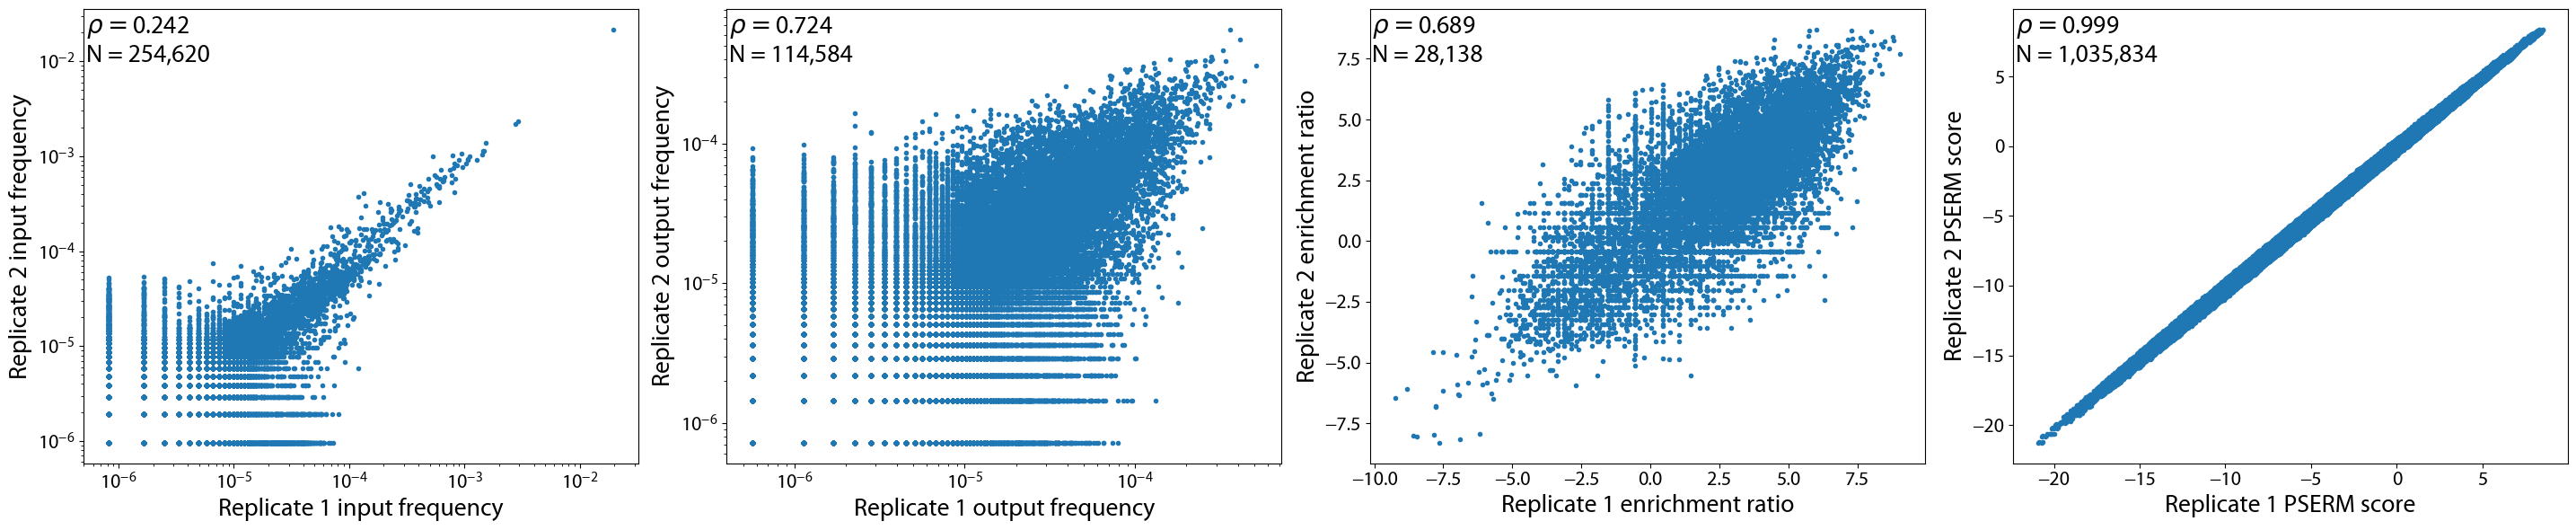

In [3]:
# Project 2 NGS_round_data setups
p2_wt = 'IDDLYPYWYG'

p2_muts_no_wt = {
    0: ['V'],
    1: ['F', 'K', 'R', 'P', 'Y'],
    2: ['T', 'H', 'K', 'N', 'Y'],
    3: ['R', 'S', 'G'],
    4: ['K'],
    5: ['R', 'G'],
    6: ['K', 'R', 'D', 'E', 'H'],
    7: ['K', 'A', 'D', 'E', 'H'],
    8: ['S', 'Q', 'D', 'E'],
    9: ['A', 'S', 'T', 'K']
}

p2_r1 = NGS_round_data(
    Round = 1, 
    sequence_type = 'mutations', 
    samples = ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], 
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_2/Rep_1/VH/', 
    wild_type = p2_wt,
    mutations_dict = p2_muts_no_wt
)
p2_r2 = NGS_round_data(
    Round = 1, 
    sequence_type = 'mutations', 
    samples = ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], 
    sample_of_interest = 'Input', 
    path = '../Input_Datasets/Project_2/Rep_2/VH/', 
    wild_type = p2_wt,
    mutations_dict = p2_muts_no_wt
)

p2_clone_set_trimmed_r1 = generate_clone_set(p2_r1, ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'])
p2_clone_set_trimmed_r2 = generate_clone_set(p2_r2, ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'])

p2_data_r1 = ngs_analysis([p2_r1], ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], clone_set = p2_clone_set_trimmed_r1)
p2_data_r2 = ngs_analysis([p2_r2], ['Input', 'AgP', 'AgN', 'QDP', 'QDN', 'EP', 'EN'], clone_set = p2_clone_set_trimmed_r2)

p2_data_r1.generate_D()
p2_data_r2.generate_D()

for sample in tqdm.tqdm(p2_data_r1.samples):
    p2_data_r1.generate_PSSM(sample)
    p2_data_r2.generate_PSSM(sample)

for sample in tqdm.tqdm(p2_data_r1.samples):
    if sample != 'Input':
        p2_data_r1.generate_PSERM(In_sample = 'Input', Out_sample = sample)
        p2_data_r2.generate_PSERM(In_sample = 'Input', Out_sample = sample)

p2_data_r1.score_all_clones_mp(method = 'PSERM')
p2_data_r2.score_all_clones_mp(method = 'PSERM')

create_specific_reproducibility_figure(p2_data_r1, p2_data_r2, 'QDN', input_sample = 'Input', show = True, rasterized = True, fname = 'Fig. 2A Specific Reproducibility.pdf',)

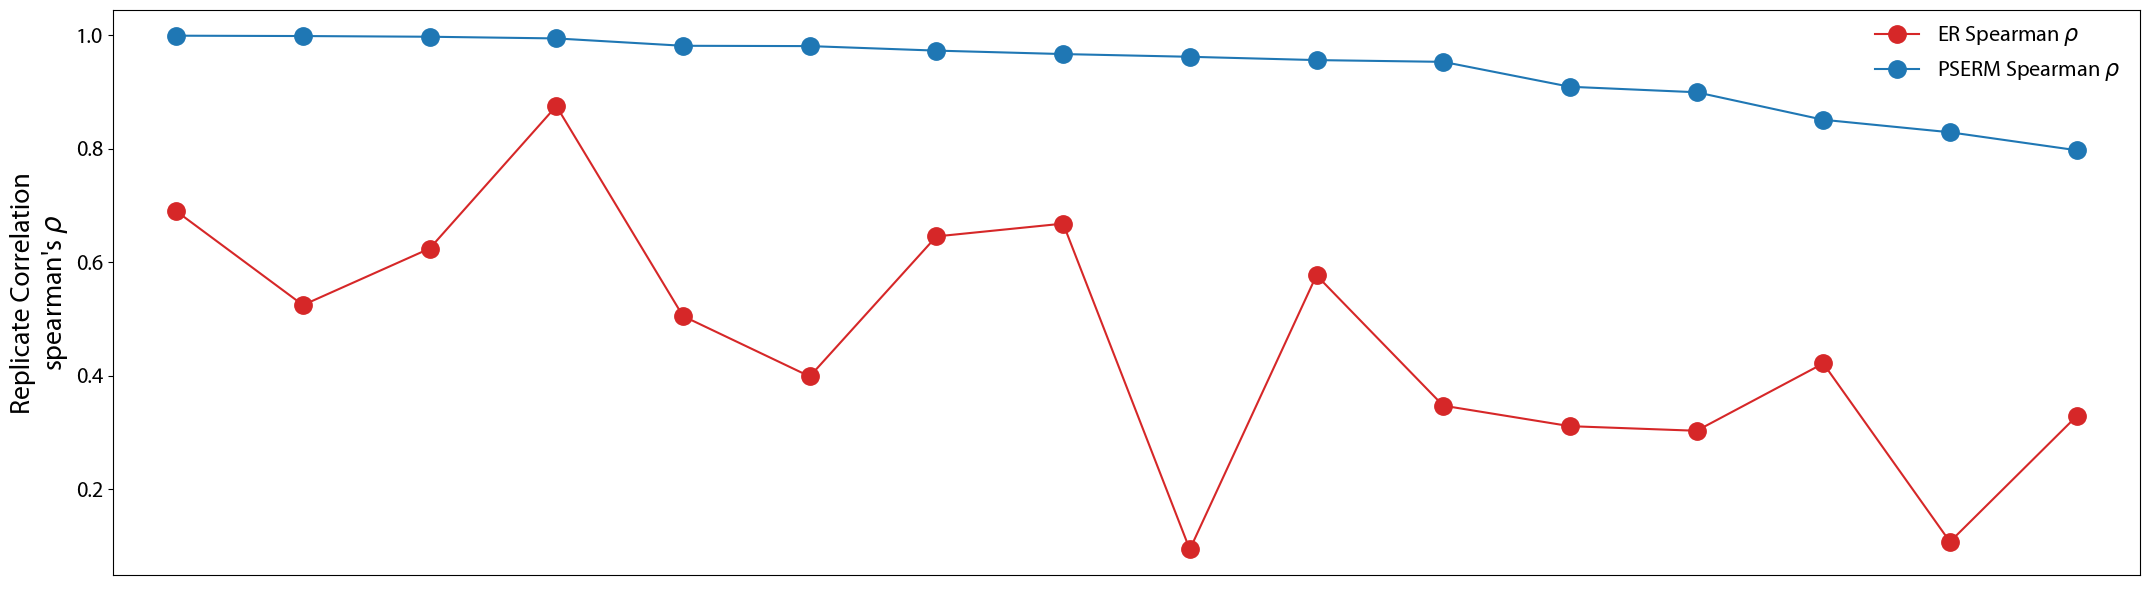

In [4]:
create_reproducibility_summary_figure(
    'Final All Datasets Reproducibility Scores.xlsx', 
    sheet_name='Sheet1', 
    fname = 'Fig. 2B Reproducibility Summary.pdf'
    )